# **Capstone Project - NLP**

---


## **Import Packages**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stopwords = list(set(nltk.corpus.stopwords.words('English')))

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d1117\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\d1117\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\d1117\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy, stanza

stanza.download('en')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

2022-03-18 16:13:06 INFO: Downloading default packages for language: en (English)...
2022-03-18 16:13:10 INFO: File exists: C:\Users\d1117\stanza_resources\en\default.zip.
2022-03-18 16:13:17 INFO: Finished downloading models and saved to C:\Users\d1117\stanza_resources.


**Beberapa pengaturan dari _packages_ yang berguna dalam keseluruhan notebook akan diatur terlebih dahulu disini.**

In [3]:
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid')

np.random.seed(45)

**Berikut ini beberapa _function_ berguna yang akan dipakai selama notebook, dideklarasikan di atas agar mudah ditemukan.**

In [4]:
def display_df(df, n = 5):
    '''
        Display the first n rows (default = 5) of a DataFrame and its shape
        Goal: To print short previews of a dataset and know its dimensions at the same time
    '''
    if n == 'all':
        display(df)
    elif type(n) == int:
        display(df.head(n))
    display(df.shape)

def count_unique(series, dropna = True):
    '''Print how many unique values are in a Series, and drop missing values by default'''
    
    return len(series.dropna().unique())

def hist_boxplot(series, xlabel = '', ylabel = '', title = '', bins = 'auto'):
    '''Create a histogram and boxplot graph side-by-side from a series'''
    plt.figure(figsize = (16, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x = series).set(xlabel = xlabel)

    plt.subplot(1, 2, 2)
    sns.histplot(x = series, bins = bins).\
        set(xlabel = xlabel, ylabel = ylabel)
    
    plt.suptitle(title)

    plt.show()

def create_wordcloud(word_list, color):
    '''Create a word cloud given a word list (adapted from Narasio's notebook)'''
    plt.subplots(figsize = (16, 16))
    
    word_cloud = WordCloud(width = 500, height = 300, background_color = "white", 
                           contour_color = color, max_words = 2000, 
                           random_state = 99, collocations = False)
    
    word_cloud.generate(' '.join(word_list))
    
    plt.imshow(word_cloud)
    plt.axis('off')
    
    plt.show()

## **Read Dataset**

**Data dibaca dari `nlp.csv`, dan ditemukan terdapat 33,722 rows serta 8 columns.**

Data dibaca dengan encoding `utf-8` untuk berjaga-jaga akan kemungkinan buku internasional.

In [5]:
df = pd.read_csv('data/nlp.csv', encoding = 'utf-8')

display_df(df)

,wikipedia_ID,freebase_ID,title,author,publication_date,genre_ID,genre,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/016lj8,Roman à clef,"Old Major, the old boar on the Manor Farm, ca..."
1,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/06nbt,Satire,"Old Major, the old boar on the Manor Farm, ca..."
2,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/0dwly,Children's literature,"Old Major, the old boar on the Manor Farm, ca..."
3,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/014dfn,Speculative fiction,"Old Major, the old boar on the Manor Farm, ca..."
4,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/02xlf,Fiction,"Old Major, the old boar on the Manor Farm, ca..."


(33722, 8)

**Dari pengecekan singkat, nampaknya nanti akan perlu menangani missing values dan tipe data.**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33722 entries, 0 to 33721
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   wikipedia_ID      33722 non-null  int64 
 1   freebase_ID       33722 non-null  object
 2   title             33722 non-null  object
 3   author            31031 non-null  object
 4   publication_date  24504 non-null  object
 5   genre_ID          30004 non-null  object
 6   genre             30004 non-null  object
 7   summary           33722 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


## **Problem Statement**

<u>**Secara bisnis, masalah yang ingin diselesaikan adalah sebagai berikut:**</u>

Seorang pemilik toko buku ingin mengadakan **pameran buku berskala besar**, dimana dia memerlukan bantuan untuk **menyusun letak buku** saat pameran agar tepat dan buku-buku dengan **alur yang serupa berada di bagian yang sama**, yang bisa didapatkan dari **summary bukunya**. Bantuan insight lain bersifat opsional.

<u>**Secara teknikal, masalah di atas akan ditranslasikan menjadi:**</u>

**Berdasarkan summary buku (dan optionally, kolom-kolom lain), kelompokkan (clustering) buku-buku yang ada** hingga dapat diatur dengan sesuai letaknya saat pameran. Karena datanya dominan berbentuk teks, maka **teknik NLP yang akan digunakan** untuk menyelesaikannya.

## **EDA**

<u>**Pertanyaan-pertanyaan menarik akan dipecah dalam beberapa bagian dan dieksplorasi dalam fase EDA untuk mempersiapkan fase-fase selanjutnya.**</u>

Beberapa pertanyaan mungkin akan memiliki **anak pertanyaannya** sendiri yang mengeksplorasi topik itu lebih dalam. Bagian **General** akan mengeksplorasi variabel tentang buku-buku yang ada dalam data secara umum, sementara bagian **Summary Buku** akan mengeksplorasi summary buku secara spesifik.

**Caveat EDA: Perhatikan bahwa ada beberapa EDA yang akan terpengaruh oleh missing values yang ada dalam data.**

Sebagai konsekuensinya, `publication date` belum akan dieksplor karena missing lebih dari 1/4, namun EDA akan tetap bisa menjadi gambaran bagus untuk memahami data yang masih ada (tidak missing) di kolom-kolom lainnya. 

In [7]:
print('Persentase Missing Value Per Kolom:')

(df.isnull().mean() * 100).round(2)

Persentase Missing Value Per Kolom:


wikipedia_ID         0.00
freebase_ID          0.00
title                0.00
author               7.98
publication_date    27.34
genre_ID            11.03
genre               11.03
summary              0.00
dtype: float64

### **General**
Mengeksplorasi variabel tentang buku-buku yang ada dalam data ini secara umum.

#### **Ada berapa unique title di dalam data ini?**

**Terdapat sekitar ~16,600 judul di dalam data kita.**

Mengingat total baris sebelumnya ada sekitar 33 ribu, maka setiap buku rata-rata terduplikasi ~2 kali dalam data.

In [8]:
dedup_df = df[['wikipedia_ID', 'freebase_ID', 'title']].\
    drop_duplicates().reset_index(drop = True)

print(f'Jumlah unique title: {len(dedup_df)}')
display_df(dedup_df)

Jumlah unique title: 16559


,wikipedia_ID,freebase_ID,title
0,620,/m/0hhy,Animal Farm
1,843,/m/0k36,A Clockwork Orange
2,986,/m/0ldx,The Plague
3,1756,/m/0sww,An Enquiry Concerning Human Understanding
4,2080,/m/0wkt,A Fire Upon the Deep


(16559, 3)

**Ada cukup banyak buku yang memiliki judul duplikat, tetapi memiliki ID berbeda.**

Apakah ini adalah buku yang sama atau berbeda? Apakah ada satu buku yang memiliki lebih dari satu ID?

In [9]:
print('Jumlah unique value per kolom:')
print(df[['wikipedia_ID', 'freebase_ID', 'title']].apply(count_unique))

dedup_df_title = dedup_df[dedup_df.duplicated('title', keep = False)].sort_values('title')
display_df(dedup_df_title, 10)

Jumlah unique value per kolom:
wikipedia_ID    16559
freebase_ID     16559
title           16277
dtype: int64


,wikipedia_ID,freebase_ID,title
10023,11603742,/m/02rl6pc,1945
7680,6992045,/m/0g_9bq,1945
15495,28724064,/m/0cz9rq3,A Casa
16330,33280874,/m/0h7n0gm,A Casa
6653,5500227,/m/0dpn1f,A Taste for Death
9020,9331797,/m/0284wmh,A Taste for Death
15682,30012820,/m/026hjn7,Abduction
5668,4576376,/m/0c9pcq,Abduction
13007,19740466,/m/04n26_j,American Beauty
12061,16995823,/m/0414ywq,American Beauty


(528, 3)

**Ada judul yang memiliki duplikat hingga 6 kali!**

Admittedly, judulnya cukup pasaran di genre tertentu.

Judul dengan duplikasi terbanyak:
Nemesis      6
Outcast      4
Inferno      4
Haunted      4
The Enemy    3
Name: title, dtype: int64


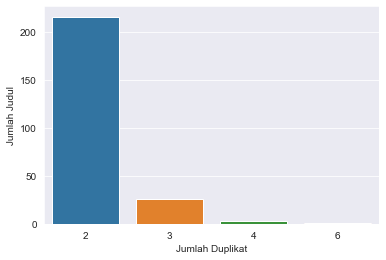

In [10]:
dup_title_count = dedup_df_title['title'].value_counts()

print('Judul dengan duplikasi terbanyak:')
print(dup_title_count.head())

dup_title_count = dup_title_count.value_counts()

sns.barplot(x = dup_title_count.index, y = dup_title_count).\
    set(xlabel = 'Jumlah Duplikat', ylabel = 'Jumlah Judul')

plt.show()

**Nampaknya judul-judul yang duplikat itu memang buku-buku unik sehingga tidak perlu pembersihan lagi nanti.**

Jika dilihat dari `author`, `publication_date`, maupun `summary`, nampaknya judul-judul duplikat ini sama memang karena kebetulan, bukan karena ada masalah input data yang perlu dikoreksi.

In [11]:
df[df['freebase_ID'].isin(dedup_df_title['freebase_ID'])].\
    drop_duplicates(['wikipedia_ID', 'freebase_ID']).sort_values('title')

,wikipedia_ID,freebase_ID,title,author,publication_date,genre_ID,genre,summary
23513,11603742,/m/02rl6pc,1945,Robert Conroy,2007-05-29,/m/0mz2,Alternate history,1945 depicts what could have happened if Japa...
18471,6992045,/m/0g_9bq,1945,William R. Forstchen,1995-08-01,/m/0mz2,Alternate history,"At the start of the novel, the United States,..."
32355,28724064,/m/0cz9rq3,A Casa,Miguel M. Abrahão,NaN,/m/01z4y,Comedy,"A Casa, tells a simple story, but its great s..."
33418,33280874,/m/0h7n0gm,A Casa,Andre Vianco,NaN,/m/01hmnh,Fantasy,Some people who have harmed others in the pas...
16026,5500227,/m/0dpn1f,A Taste for Death,Peter O'Donnell,NaN,/m/02n4kr,Mystery,Canadian Dinah Pilgrim (blind since 11) and h...
...,...,...,...,...,...,...,...,...
29837,21559095,/m/05h23d8,Winter,John Marsden,2000,/m/03mfnf,Young adult literature,For twelve years Winter has been haunted. Her...
33091,31738453,/m/0gttc00,Wither,NaN,NaN,NaN,NaN,"Wither follows Wendy, a young college student..."
33092,31738907,/m/0gtwwck,Wither,NaN,NaN,/m/06n90,Science Fiction,Wither describes a future where genetic engin...
8800,2346922,/m/075jg4,World's End,"Upton Sinclair, Jr.",1940,/m/0hwxm,Historical novel,Lanny Budd is a teenage student at a private ...


#### **Ada berapa genre dalam data ini?**

**Terdapat 228 genre ID dan 227 label genre.**

Hmm, genre ID apa yang tidak memiliki pasangan label genre unik?

In [12]:
print(f"Jumlah genre ID: {count_unique(df['genre_ID'])}")
print(f"Jumlah label genre: {count_unique(df['genre'])}")

Jumlah genre ID: 228
Jumlah label genre: 227


**Nampaknya genre `Mystery` memiliki dua genre ID!**

Duplikasi ini nanti perlu dihilangkan. Berdasarkan pengecekan di internet, ID `/m/0fq56vk` tidak dapat ditemukan, tetapi ID `/m/0fq56vk` memang merupakan ID untuk genre misteri.

In [13]:
dedup_df = df[['genre_ID', 'genre']].drop_duplicates()

dedup_df[dedup_df.duplicated('genre', keep = False)]

,genre_ID,genre
63,/m/02n4kr,Mystery
30414,/m/0fq56vk,Mystery


<u>**Sub-Pertanyaan: Berapa banyak buku yang berada di satu genre umumnya?**</u>
    
Perhatikan bahwa pasti ada duplikasi buku, yakni buku yang masuk dalam lebih dari satu genre.

**Ada genre dengan banyak buku, tetapi sebagian besar genre memiliki sedikit buku.**

Data sangat skew ke kanan dengan banyak outlier, padahal sebenarnya sebagian besar genre memiliki <30 buku seperti terlihat pada five-number summarynya. **Genre yang mendominasi nampaknya genre fiksi dan fantasi**.

Genre dengan buku terbanyak:
genre
Fiction                4747
Speculative fiction    4314
Science Fiction        2870
Novel                  2463
Fantasy                2413
Name: freebase_ID, dtype: int64


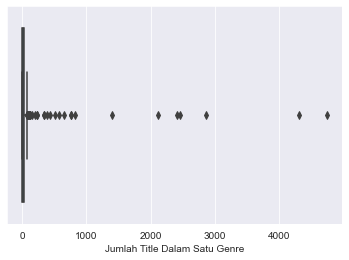

In [14]:
genre_count = df.groupby('genre')['freebase_ID'].count().sort_values(ascending = False)

print('Genre dengan buku terbanyak:')
print(genre_count.head())

sns.boxplot(x = genre_count).set(xlabel = 'Jumlah Title Dalam Satu Genre')
plt.show()

In [15]:
print(genre_count.describe())

count     227.000000
mean      132.176211
std       546.538046
min         1.000000
25%         2.000000
50%         7.000000
75%        29.000000
max      4747.000000
Name: freebase_ID, dtype: float64


<u>**Sub-Pertanyaan: Berapa banyak genre yang dimiliki satu buku pada umumnya?**</u>

Kebalikan dari pertanyaan sebelumnya.

**Sebagian besar buku termasuk dalam 1-3 genre.**

Namun ada pula buku yang memiliki hingga 9 genre! Sebenarnya hal ini tidak hanya merefleksikan variasi dari buku itu sendiri, namun juga bergantung dari apakah orang-orang yang membuat data ini seimbang dalam memberikan detail genre kepada setiap buku.

Buku dengan jumlah genre terbanyak:
               Title  Jumlah Genre
0        World War Z            11
11       The Passage            10
21       I Am Legend             9
30  The Time Machine             9
39      Frankenstein             9


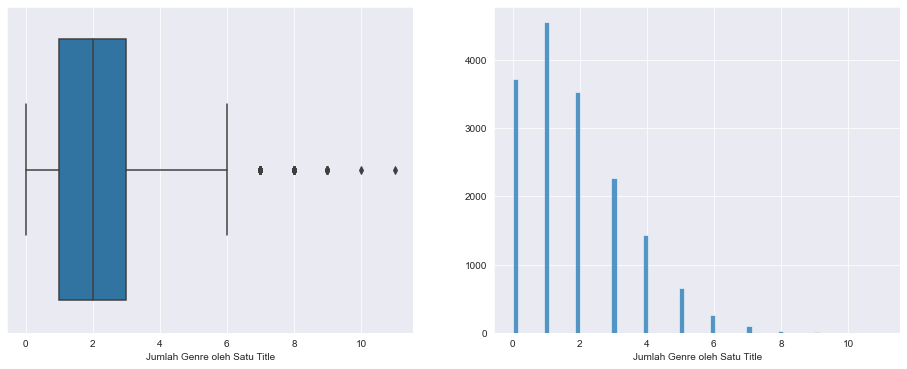

In [16]:
genre_count = df.groupby('freebase_ID')['genre'].count().sort_values(ascending = False)

print('Buku dengan jumlah genre terbanyak:')
print(genre_count.reset_index().\
      merge(df[['freebase_ID', 'title']], how = 'left', on = 'freebase_ID').\
      rename(columns = {'genre': 'Jumlah Genre', 'title': 'Title'}).\
      drop_duplicates()[['Title', 'Jumlah Genre']].head())

hist_boxplot(genre_count, xlabel = 'Jumlah Genre oleh Satu Title')
plt.show()

#### **Ada berapa unique author di sini?**

**Terdapat sekitar ~4,700 author unik dalam stok toko buku ini.**

Cukup banyak juga, dan jika dihitung dengan 16,600 buku unik, maka ada sekitar ~4 buku per author secara rata-rata.

In [17]:
print(f"Jumlah unique author: {count_unique(df['author'])}")

Jumlah unique author: 4714


<u>**Sub-Pertanyaan: Berapa banyak buku yang dimiliki satu author umumnya?**</u>

**Sebagian besar author memiliki 1-5 buku, tetapi ada sekumpulan author dengan ratusan buku dalam data ini!**

Jika dilihat daftar para author dengan judul-judul terbanyak, daftar ini didominasi 100% dengan penulis fiksi terkenal barat, umumnya dengan genre misteri, sci-fi, thriller, dan fantasi (terutama misteri dan fantasi, yang memang nampaknya tipe-tipe genre yang dapat menghasilkan serial panjang).

Author dengan buku terbanyak:
author
Agatha Christie         317
Stephen King            220
Edgar Rice Burroughs    203
John Dickson Carr       185
Dean Koontz             177
K. A. Applegate         175
Terry Pratchett         171
Franklin W. Dixon       167
Ruth Rendell            166
Rex Stout               164
Name: freebase_ID, dtype: int64


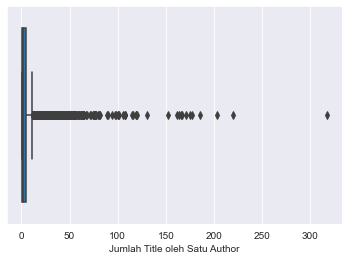

In [18]:
author_count = df.groupby('author')['freebase_ID'].count().sort_values(ascending = False)

print('Author dengan buku terbanyak:')
print(author_count.head(10))

sns.boxplot(x = author_count).set(xlabel = 'Jumlah Title oleh Satu Author')
plt.show()

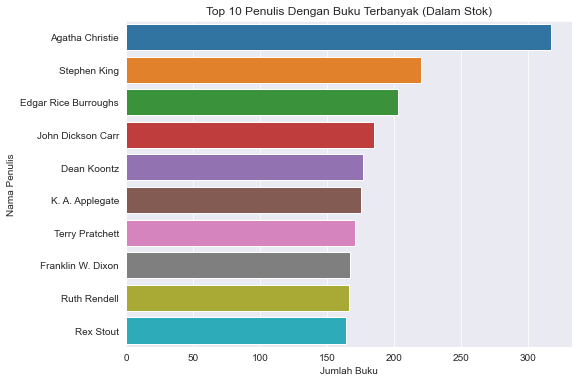

In [182]:
plt.figure(figsize = (8, 6))

sns.barplot(x = author_count[0:10], y = author_count[0:10].index).\
    set(xlabel = 'Jumlah Buku', ylabel = 'Nama Penulis', 
        title = 'Top 10 Penulis Dengan Buku Terbanyak (Dalam Stok)')

plt.show()

In [19]:
author_count.describe()

count    4714.000000
mean        6.582732
std        15.042582
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       317.000000
Name: freebase_ID, dtype: float64

#### **Kesimpulan**

- **Terdapat sekitar ~16,600 buku unik di dalam data kita**  
Beberapa di antaranya memiliki judul yang duplikat, tetapi otherwise adalah buku yang berbeda.


- **Terdapat 227 genre di dalam data kita** (228 - 1 genre duplikat)  
Sebagian besar genre terdiri dari <30 buku, namun **genre fiksi dan fantasi mendominasi** dan memiliki ribuan buku.


- **Sebagian besar buku hanya termasuk dalam 1-3 genre**


- **Terdapat sekitar ~4,700 author unik di dalam data kita**  
Sebagian besar menulis 1-5 buku dalam stok kita, namun **beberapa author memiliki ratusan buku** dan didominasi oleh **author cerita fiksi** dengan **genre fantasi, misteri, sci-fi, dan thriller**, yang memang cenderung dapat memiliki serial panjang.

### **Summary Buku**
Mengeksplorasi summary buku secara spesifik.

Caveat: Ini adalah hitungan ballpark yang cukup mendekati namun tidak exact, karena akan perlu banyak preprocessing yang lebih mendalam di tahap-tahap selanjutnya agar bisa mendapatkan angka persis.

#### **Berapa panjang summary pada umumnya?**

**Data akan dideduplikasi agar kita tidak memproses lebih banyak summary daripada yang diperlukan...**

In [20]:
dedup_df = df.drop_duplicates('freebase_ID')

display_df(dedup_df)

,wikipedia_ID,freebase_ID,title,author,publication_date,genre_ID,genre,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/016lj8,Roman à clef,"Old Major, the old boar on the Manor Farm, ca..."
5,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,/m/06n90,Science Fiction,"Alex, a teenager living in near-future Englan..."
11,986,/m/0ldx,The Plague,Albert Camus,1947,/m/02m4t,Existentialism,The text of The Plague is divided into five p...
15,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,NaN,The argument of the Enquiry proceeds by a ser...
16,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,/m/03lrw,Hard science fiction,The novel posits that space around the Milky ...


(16559, 8)

<u>**Secara Jumlah Karakter**</u>

**Sebagian besar summary memiliki panjang 0-3325 karakter, tetapi ada beberapa buku dengan summary sangat panjang!**

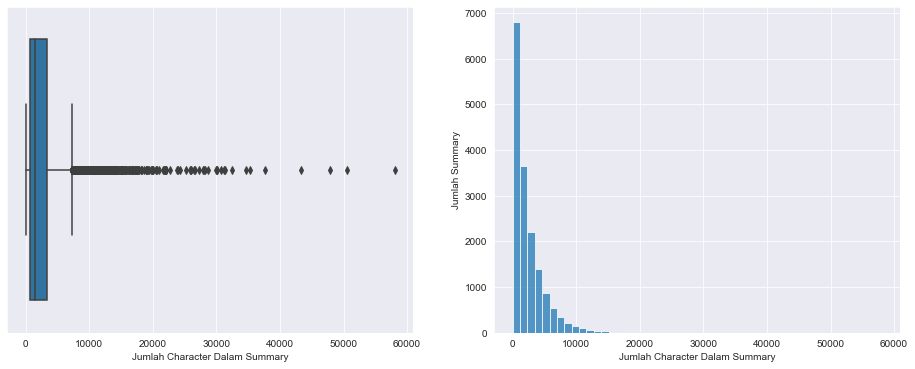

Summary statistik dari panjang karakter:


count    16559.000000
mean      2511.108944
std       2903.074330
min         11.000000
25%        710.000000
50%       1550.000000
75%       3325.000000
max      58019.000000
Name: summary, dtype: float64

In [21]:
summary_len = dedup_df['summary'].str.len()

hist_boxplot(summary_len, 
             xlabel = 'Jumlah Character Dalam Summary', 
             ylabel = 'Jumlah Summary', bins = 50)

print('Summary statistik dari panjang karakter:')
summary_len.describe()

**Buku-buku dengan summary terpanjang memiliki summary seperti outline buku lengkap.**

Mengecek beberapa summary buku terpanjang, nampaknya detail cerita dituliskan dengan sangat lengkap dalam summary bukunya sehingga menjadi panjang. Terkadang, hal itu juga disebabkan karena bukunya sendiri juga memiliki cerita panjang, seperti "The History of Tom Jones, a Foundling" yang ceritanya dibahas dalam 18 buku.

In [22]:
print('Buku dengan summary terpanjang:')
print(summary_len.sort_values(ascending = False).\
      reset_index().\
      merge(dedup_df[['title', 'summary']], how = 'left', 
            left_on = 'index', right_index = True).\
      rename(columns = {'summary_x': 'Panjang Summary', 'title': 'Title', 'summary_y': 'Summary'}).\
      drop_duplicates()[['Title', 'Panjang Summary', 'Summary']].head())

Buku dengan summary terpanjang:
                                   Title  Panjang Summary  \
0                        Kushiel's Mercy            58019   
1  The History of Tom Jones, a Foundling            50560   
2                      Dawkins vs. Gould            47829   
3                             Fire World            43352   
4                     March to the Stars            37653   

                                             Summary  
0   Upon reaching the City of Elua, Sidonie and I...  
1   The novel's events occupy eighteen books. Squ...  
2   In the introductory chapter the author points...  
3   It opens on the planet Co:pern:ica with Couns...  
4   The story opens in the restored city of Voita...  


<u>**Secara Jumlah Kata**</u>

**Sebagian besar summary memiliki panjang sekitar 1-2 halaman tulisan, tetapi ada beberapa buku dengan summary hingga 20 halaman!**

Asumsi: satu halaman ~= 450-500 kata.

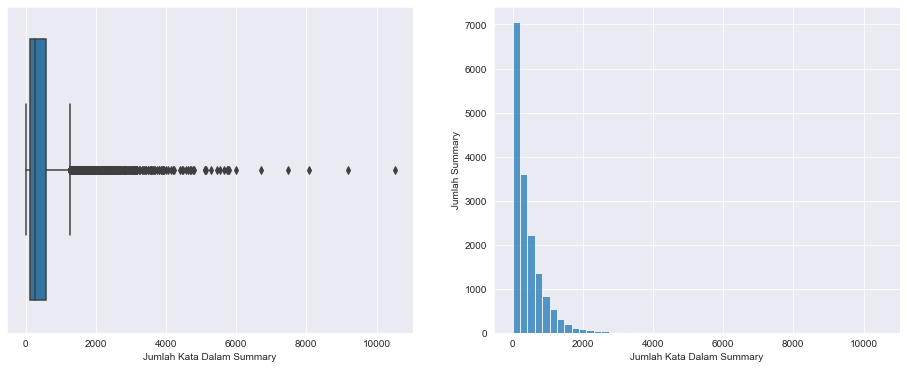

Summary statistik dari jumlah kata:


count    16559.000000
mean       437.574974
std        509.715148
min          1.000000
25%        123.000000
50%        269.000000
75%        578.500000
max      10514.000000
Name: summary, dtype: float64

In [23]:
summary_len = dedup_df['summary'].\
    str.replace('\W', ' ', regex = True).str.split().apply(len)

hist_boxplot(summary_len, 
             xlabel = 'Jumlah Kata Dalam Summary', 
             ylabel = 'Jumlah Summary', bins = 50)

print('Summary statistik dari jumlah kata:')
summary_len.describe()

**Buku-buku dengan jumlah kata dan jumlah karakter terpanjang kurang lebih sama.**

Kesimpulannya kurang lebih sama dengan sebelumnya.

In [24]:
print('Buku dengan summary terpanjang:')
print(summary_len.sort_values(ascending = False).\
      reset_index().\
      merge(dedup_df[['title', 'summary']], how = 'left', 
            left_on = 'index', right_index = True).\
      rename(columns = {'summary_x': 'Panjang Summary', 'title': 'Title', 'summary_y': 'Summary'}).\
      drop_duplicates()[['Title', 'Panjang Summary', 'Summary']].head())

Buku dengan summary terpanjang:
                                   Title  Panjang Summary  \
0                        Kushiel's Mercy            10514   
1  The History of Tom Jones, a Foundling             9176   
2                             Fire World             8064   
3                      Dawkins vs. Gould             7489   
4                     March to the Stars             6716   

                                             Summary  
0   Upon reaching the City of Elua, Sidonie and I...  
1   The novel's events occupy eighteen books. Squ...  
2   It opens on the planet Co:pern:ica with Couns...  
3   In the introductory chapter the author points...  
4   The story opens in the restored city of Voita...  


**Ada buku-buku dengan summary terlalu pendek, yang mungkin tidak dapat dikelompokkan nantinya.**

Tidak hanya pendek, summarynya juga tidak bermakna isinya. Berdasarkan penyelidikan lebih lanjut, summary baru mulai bermakna mulai dari panjang 8 kata ke atas. Buku-buku ini mungkin tidak dapat diikutkan dalam layout karena tidak memiliki deskripsi jelas.

In [25]:
print('Buku dengan summary terpendek:')
print(summary_len.sort_values().\
      reset_index().\
      merge(dedup_df[['title', 'summary']], how = 'left', 
            left_on = 'index', right_index = True).\
      rename(columns = {'summary_x': 'Panjang Summary', 'title': 'Title', 'summary_y': 'Summary'}).\
      drop_duplicates()[['Title', 'Panjang Summary', 'Summary']].head(20))

Buku dengan summary terpendek:
                                      Title  Panjang Summary  \
0                                     Flame                1   
1                     The Deathlord of Ixia                1   
2           Cecily Parsley's Nursery Rhymes                1   
3           Chucaro: Wild Pony of the Pampa                1   
4                                    Lurulu                1   
5                      The Caverns of Kalte                1   
6                      The Eyes of Darkness                1   
7   Guardians of Ga'Hoole Book 4: The Siege                1   
8                       Deathstalker Honour                2   
9                      Deathstalker Destiny                2   
10                     No Place for Grubbs!                2   
11                         Deathstalker War                2   
12      The Adventures of Super Diaper Baby                2   
13                    The American Claimant                2   
14       

#### **Apakah panjang summary bervariasi secara genre dan author?**

**Panjang summary berdasarkan kata digunakan untuk pertanyaan kali ini.**

Perhatikan caveat mengenai perhitungan summary sebelumnya! 

In [26]:
dedup_df['summary_length'] = summary_len

display_df(dedup_df)

,wikipedia_ID,freebase_ID,title,author,publication_date,genre_ID,genre,summary,summary_length
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/016lj8,Roman à clef,"Old Major, the old boar on the Manor Farm, ca...",955
5,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,/m/06n90,Science Fiction,"Alex, a teenager living in near-future Englan...",1036
11,986,/m/0ldx,The Plague,Albert Camus,1947,/m/02m4t,Existentialism,The text of The Plague is divided into five p...,1132
15,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,NaN,The argument of the Enquiry proceeds by a ser...,2894
16,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,/m/03lrw,Hard science fiction,The novel posits that space around the Milky ...,736


(16559, 9)

**Panjang summary nampaknya dapat bervariasi per author.**

Agar lebih terlihat dan tidak ditarik oleh jumlah buku yang sedikit saja, maka perhitungan difilter hanya untuk author yang memiliki lebih dari tiga buku dalam data ini. Nampaknya ada beberapa author yang beberapa karyanya memang membutuhkan deskripsi yang lebih panjang dari normalnya (telah dicek secara manual dalam data). 

In [183]:
author_sum_length = dedup_df.groupby('author')[['freebase_ID', 'summary_length']].\
    agg({'freebase_ID': 'count', 'summary_length': 'mean'}).\
    rename(columns = {'freebase_ID': 'Jumlah Title', 'summary_length': 'Panjang Summary'})

author_sum_length = author_sum_length[author_sum_length['Jumlah Title'] > 3]
author_sum_length = author_sum_length.sort_values('Panjang Summary', ascending = False)

author_sum_length

,Jumlah Title,Panjang Summary
author,,
Jacqueline Carey,7,3410.857143
John Ringo,6,2966.666667
Chris D'Lacey,6,2263.666667
Plato,5,1948.800000
Thomas Middleton,5,1945.800000
...,...,...
"William F. Buckley, Jr.",9,53.000000
Martin Day,4,44.000000
Bruce Cook,11,36.090909


In [28]:
print('Summary statistik dari jumlah kata per author:')

author_sum_length['Panjang Summary'].describe()

Summary statistik dari jumlah kata per author:


count     941.000000
mean      472.238184
std       316.301349
min        29.500000
25%       254.250000
50%       416.333333
75%       622.000000
max      3410.857143
Name: Panjang Summary, dtype: float64

**Chart tambahan untuk visualisasi dalam presentasi.**

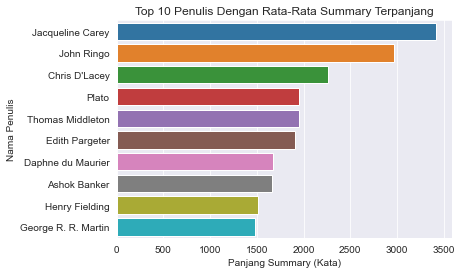

In [202]:
author_sum_length_top = author_sum_length.iloc[0:10]

sns.barplot(x = author_sum_length_top['Panjang Summary'], y = author_sum_length_top.index).\
    set(xlabel = 'Panjang Summary (Kata)', ylabel = 'Nama Penulis', 
        title = 'Top 10 Penulis Dengan Rata-Rata Summary Terpanjang')

plt.show()

**Panjang summary nampaknya dapat juga bervariasi per genre, meskipun lebih sedikit daripada variasi dalam author.**

Agar lebih terlihat dan tidak ditarik oleh jumlah buku yang sedikit saja, maka perhitungan difilter hanya untuk genre yang memiliki lebih dari tiga buku dalam data ini. Nampaknya ada beberapa genre yang memiliki deskripsi relatif lebih banyak atau lebih sedikit (telah dicek secara manual dalam data).

Untuk 5 genre teratas, memang nampaknya ini adalah genre-genre yang alur cerita atau isinya akan makan waktu lama, dan di sisi lain, 5 genre terbawah memang tipe-tipe yang memiliki alur sulit dijelaskan dalam summary (_how do you summarize an encyclopedia?_).

In [207]:
genre_sum_length = dedup_df.groupby('genre')[['freebase_ID', 'summary_length']].\
    agg({'freebase_ID': 'count', 'summary_length': 'mean'}).\
    rename(columns = {'freebase_ID': 'Jumlah Title', 'summary_length': 'Panjang Summary'})

genre_sum_length = genre_sum_length[genre_sum_length['Jumlah Title'] > 3]
genre_sum_length = genre_sum_length.sort_values('Panjang Summary', ascending = False)

genre_sum_length

,Jumlah Title,Panjang Summary
genre,,
Space opera,7,1464.428571
Subterranean fiction,4,1363.500000
Roman à clef,12,1196.916667
Treatise,5,1176.200000
Time travel,4,1141.500000
...,...,...
Graphic novel,6,147.833333
Anthology,4,102.000000
Prose,4,90.750000


In [208]:
print('Summary statistik dari jumlah kata per genre:')

genre_sum_length['Panjang Summary'].describe()

Summary statistik dari jumlah kata per genre:


count     108.000000
mean      514.664384
std       267.996341
min        67.250000
25%       365.065627
50%       457.884058
75%       586.450876
max      1464.428571
Name: Panjang Summary, dtype: float64

**Chart tambahan untuk visualisasi dalam presentasi.**

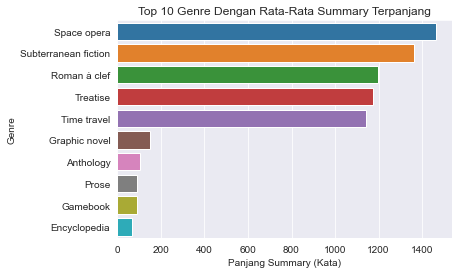

In [209]:
top_bottom_index = list(range(0, 5)) + list(range(-5, 0))

genre_sum_length_top = genre_sum_length.iloc[top_bottom_index]

sns.barplot(x = genre_sum_length_top['Panjang Summary'], y = genre_sum_length_top.index).\
    set(xlabel = 'Panjang Summary (Kata)', ylabel = 'Genre', 
        title = 'Top 10 Genre Dengan Rata-Rata Summary Terpanjang')

plt.show()

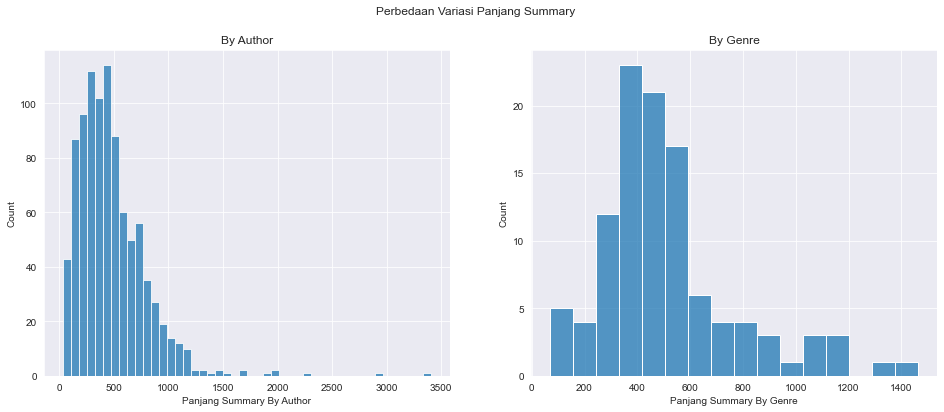

In [31]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
sns.histplot(x = author_sum_length['Panjang Summary']).\
    set(xlabel = 'Panjang Summary By Author', title = 'By Author')

plt.subplot(1, 2, 2)
sns.histplot(x = genre_sum_length['Panjang Summary']).\
    set(xlabel = 'Panjang Summary By Genre', title = 'By Genre')

plt.suptitle('Perbedaan Variasi Panjang Summary')
plt.show()

#### **Kata-kata apa yang paling sering muncul di dalam summary?**

(selain kata-kata stopwords)

**Dilakukan beberapa preprocessing untuk membersihkan summary.**

Preprocessing ini dilakukan seperlunya untuk tujuan EDA ini, tidak dimaksudkan untuk menggantikan preprocessing yang lebih lengkap nantinya.

1. Menghilangkan tanda baca dan dobel spasi
2. Membuat menjadi huruf kecil
3. Split kata

In [32]:
dedup_df['cleaner_summary'] = dedup_df['summary'].\
    str.replace('\W', ' ', regex = True).\
    str.replace('  +', ' ', regex = True).str.strip().\
    str.lower().str.split(' ')

dedup_df['cleaner_summary'].head()

0     [old, major, the, old, boar, on, the, manor, f...
5     [alex, a, teenager, living, in, near, future, ...
11    [the, text, of, the, plague, is, divided, into...
15    [the, argument, of, the, enquiry, proceeds, by...
16    [the, novel, posits, that, space, around, the,...
Name: cleaner_summary, dtype: object

4. Stemming dan menghilangkan stopwords

Stemming dilakukan menggunakan SnowballStemmer atau Porter2, yang merupakan versi _improved_ dari PorterStemmer.

In [33]:
sb = SnowballStemmer(language = 'english')

dedup_df['cleaner_summary'] = dedup_df['cleaner_summary'].apply(lambda x: [sb.stem(word) for word in x if word not in stopwords])

display_df(dedup_df['cleaner_summary'])

0     [old, major, old, boar, manor, farm, call, ani...
5     [alex, teenag, live, near, futur, england, lea...
11    [text, plagu, divid, five, part, town, oran, t...
15    [argument, enquiri, proceed, seri, increment, ...
16    [novel, posit, space, around, milki, way, divi...
Name: cleaner_summary, dtype: object

(16559,)

**Daftar kata semua summary kemudian digabungkan untuk penggunaan selanjutnya.**

In [34]:
dedup_df['cleaner_summary'] = dedup_df['cleaner_summary'].apply(lambda x: ' '.join(x))

cleaner_summary = ' '.join(dedup_df['cleaner_summary']).split(' ')

cleaner_summary[0:5]

['old', 'major', 'old', 'boar', 'manor']

**Kata-kata yang paling umum nampaknya cukup berbau "adventure".**

_Take, find, back, return, time_ adalah kata-kata yang berhubungan dengan mulainya sebuah _adventure_ (_see struktur monomyth_). Selain itu, ada juga kata-kata seputar perang/konflik dan keluarga/_loved ones_. 

_One_ dan _two_ memiliki frekuensi cukup besar namun tidak terlalu bermakna, yang mengindikasikan mungkin perlu dibersihkan sebagai stopwords nantinya.

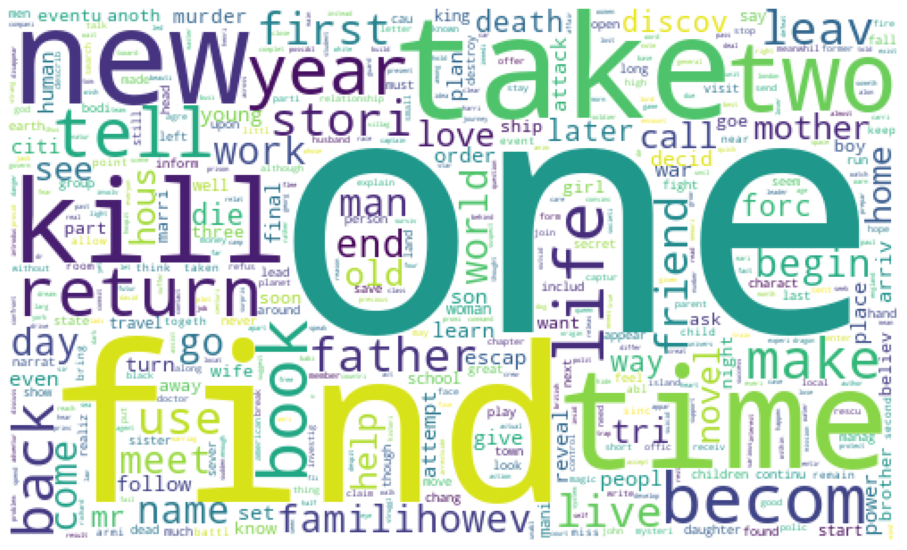

In [35]:
create_wordcloud(cleaner_summary, 'blue')

Menghilangkan _one_ dan _two_ agar tidak muncul di eksplorasi EDA selanjutnya.

In [36]:
dedup_df['cleaner_summary'] = dedup_df['cleaner_summary'].\
    str.replace('one', '').str.replace('two', '').\
    str.replace(' +', ' ', regex = True)

display_df(dedup_df, 3)

,wikipedia_ID,freebase_ID,title,author,publication_date,genre_ID,genre,summary,summary_length,cleaner_summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/016lj8,Roman à clef,"Old Major, the old boar on the Manor Farm, ca...",955,old major old boar manor farm call anim farm m...
5,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,/m/06n90,Science Fiction,"Alex, a teenager living in near-future Englan...",1036,alex teenag live near futur england lead gang ...
11,986,/m/0ldx,The Plague,Albert Camus,1947,/m/02m4t,Existentialism,The text of The Plague is divided into five p...,1132,text plagu divid five part town oran thousand ...


(16559, 10)

#### **Apakah kata-kata yang umum bervariasi antar genre?**
(selain kata-kata stopwords)

**DataFrame yang berisi gabungan summary per genre dibuat untuk dilakukan perhitungan.**

In [212]:
genre_words_df = df.merge(dedup_df[['freebase_ID', 'cleaner_summary']], 
                          how = 'left', on = 'freebase_ID').\
    groupby('genre')[['cleaner_summary', 'freebase_ID']].\
    agg({'cleaner_summary': lambda x: ' '.join(x), 'freebase_ID': 'count'}).\
    rename(columns = {'freebase_ID': 'title count'}).reset_index()

display_df(genre_words_df)

,genre,cleaner_summary,title count
0,Absurdist fiction,play open rosencrantz guildenstern bet coin fl...,2
1,Adventure,pine cove suffer major crisi town psychiatrist...,9
2,Adventure novel,1757 moonfleet small villag near sea south eng...,60
3,Albino bias,mysteri stranger griffin arriv local inn engli...,2
4,Alien invasion,galact hegemoni allianc assort alien race sent...,1


(179, 3)

**Singkat cerita, nampaknya kata-kata populer di genre dengan buku terbanyak cukup penuh darah 🤣.**

Dari kata-kata teratasnya, nampaknya genre-genre ini penuh konflik sekali.

In [213]:
genre_words_df['top 5 words'] = genre_words_df['cleaner_summary'].str.split(' ').\
    apply(lambda x: list(pd.Series(x).value_counts().index[0:5]))

genre_words_df.columns = genre_words_df.columns.str.title()

display_df(genre_words_df[['Genre', 'Title Count', 'Top 5 Words']].\
           sort_values('Title Count', ascending = False), 10)

,Genre,Title Count,Top 5 Words
139,Science Fiction,2551,"[human, find, time, take, world]"
151,Speculative fiction,1438,"[find, kill, take, time, return]"
22,Children's literature,1152,"[find, take, get, tell, friend]"
58,Fiction,943,"[life, father, becom, take, year]"
104,Novel,925,"[novel, life, becom, famili, father]"
100,Mystery,734,"[murder, find, kill, take, man]"
37,Crime Fiction,672,"[murder, find, kill, investig, man]"
54,Fantasy,624,"[find, kill, take, back, return]"
161,Thriller,568,"[kill, find, take, alex, murder]"
178,Young adult literature,321,"[get, find, tell, go, friend]"


(179, 3)

**Ada variasi yang lebih banyak jika dilihat hingga top 50.**

Terdapat beberapa kata yang selalu populer seperti find, take, time, beberapa variasi spesifik seperti "vampir" untuk Horror, "love" untuk Romance, serta nama-nama spesifik seperti "bond" untuk Spy dan "alex" untuk Thriller.

In [214]:
display_df(genre_words_df[['Genre', 'Title Count', 'Top 5 Words']].\
           sort_values('Title Count', ascending = False), 50)

,Genre,Title Count,Top 5 Words
139,Science Fiction,2551,"[human, find, time, take, world]"
151,Speculative fiction,1438,"[find, kill, take, time, return]"
22,Children's literature,1152,"[find, take, get, tell, friend]"
58,Fiction,943,"[life, father, becom, take, year]"
104,Novel,925,"[novel, life, becom, famili, father]"
100,Mystery,734,"[murder, find, kill, take, man]"
37,Crime Fiction,672,"[murder, find, kill, investig, man]"
54,Fantasy,624,"[find, kill, take, back, return]"
161,Thriller,568,"[kill, find, take, alex, murder]"
178,Young adult literature,321,"[get, find, tell, go, friend]"


(179, 3)

**Ilustrasi tambahan untuk genre horror.**

Kata-kata yang umum tetap sering muncul, seperti find, tell, begin, tetapi ada kata-kata spesifik seperti vampir, demon, night, dan entah kenapa nama Anita 🤣.

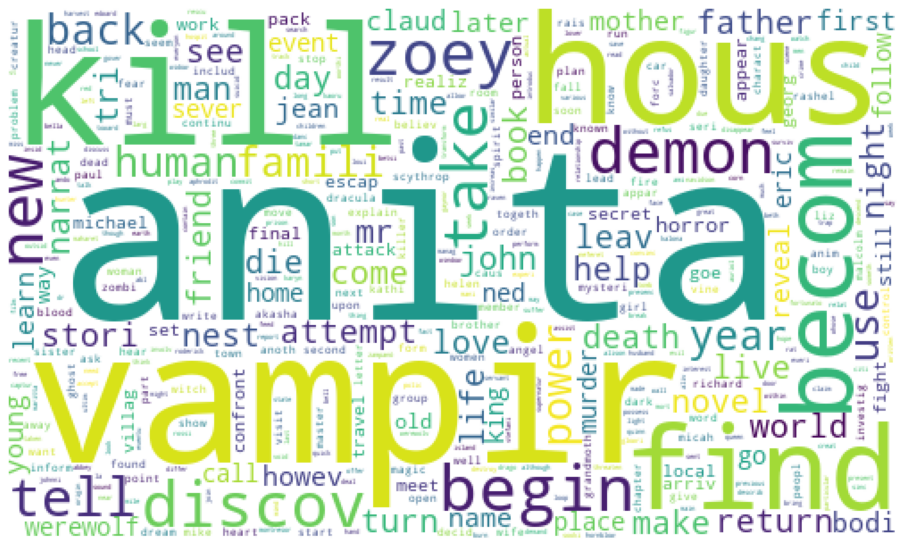

In [218]:
horror_summaries = genre_words_df.loc[genre_words_df['Genre'] == 'Horror', 
                                      'Cleaner_Summary']

create_wordcloud(horror_summaries, 'green')

#### **Kesimpulan**

- **Sebagian besar buku memiliki summary sekitar 1-2 halaman**  
Ada beberapa buku yang memiliki summary hingga 20 halaman, tetapi ada pula **buku-buku yang memiliki summary yang singkat dan tidak deskriptif**. Buku dengan summary <= 7 kata umumnya tidak deskriptif dan perlu dihilangkan nanti.


- **Panjang summary dapat bervariasi berdasarkan genre dan author**  
Panjang summary nampaknya dapat dipengaruhi oleh apakah karya dari genre atau author tersebut cenderung perlu deskripsi panjang atau justru tidak bisa dideskripsikan sebagai summary. Umumnya, variasi panjang lebih ekstrem antar author versus antar genre.


- **Kata-kata yang umum dalam summary berbau adventure serta penuh konflik/kekerasan**  
Secara garis besar, summary juga **didominasi oleh genre fiksi**, dan kata-kata yang paling umum adalah seputar adventure/monomyth atau konflik/kekerasan. Kata-kata lain yang umum adalah **angka satu dan dua (perlu ditambahkan menjadi stopwords)** dan kata-kata seputar keluarga dan loved ones.

## **Data Preprocessing**

**Data preprocessing akan dilakukan sebelum memasuki proses NLP.**

Preprocessing general akan dilakukan, diikuti dengan preprocessing spesifik untuk NLP.

### **Preprocessing General**

#### **Data Type Check**

**`wikipedia_ID` dan `publication_date` perlu dikoreksi jika akan dipakai.**

`wikipedia_ID` seharusnya menjadi `object` meskipun IDnya berupa angka, sementara `publication_date` mestinya antara tipe `datetime` atau `integer` (ada beberapa value yang bukan YYYY-MM-DD).

In [40]:
df.head()

,wikipedia_ID,freebase_ID,title,author,publication_date,genre_ID,genre,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/016lj8,Roman à clef,"Old Major, the old boar on the Manor Farm, ca..."
1,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/06nbt,Satire,"Old Major, the old boar on the Manor Farm, ca..."
2,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/0dwly,Children's literature,"Old Major, the old boar on the Manor Farm, ca..."
3,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/014dfn,Speculative fiction,"Old Major, the old boar on the Manor Farm, ca..."
4,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/02xlf,Fiction,"Old Major, the old boar on the Manor Farm, ca..."


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33722 entries, 0 to 33721
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   wikipedia_ID      33722 non-null  int64 
 1   freebase_ID       33722 non-null  object
 2   title             33722 non-null  object
 3   author            31031 non-null  object
 4   publication_date  24504 non-null  object
 5   genre_ID          30004 non-null  object
 6   genre             30004 non-null  object
 7   summary           33722 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


**Data akan dibaca ulang dari file serta semua kolom dibaca sebagai `object` untuk mengoreksi tipe data.**

Hal ini dilakukan untuk memastikan tidak ada angka yang hilang di awal `wikipedia_ID`, misalnya jika ada ID yang dimulai dengan angka 0.

In [135]:
df = pd.read_csv('data/nlp.csv', encoding = 'utf-8', dtype = 'string')

display_df(df)

,wikipedia_ID,freebase_ID,title,author,publication_date,genre_ID,genre,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/016lj8,Roman à clef,"Old Major, the old boar on the Manor Farm, ca..."
1,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/06nbt,Satire,"Old Major, the old boar on the Manor Farm, ca..."
2,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/0dwly,Children's literature,"Old Major, the old boar on the Manor Farm, ca..."
3,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/014dfn,Speculative fiction,"Old Major, the old boar on the Manor Farm, ca..."
4,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,/m/02xlf,Fiction,"Old Major, the old boar on the Manor Farm, ca..."


(33722, 8)

**`publication_date` akan dibuat uniform menjadi tipe `float` dan hanya berupa tahun.**

Semua tanggal akan digabung menjadi YYYY saja, karena (1) tingkat akurasi tahun sudah cukup, (2) `publication_date` terdiri dari beberapa variasi dengan satu-satunya _common denominator_ adalah tahun:
- Variasi 4 karakter = YYYY
- Variasi 7 karakter = YYYY-MM
- Variasi 10 karakter = YYYY-MM-DD

In [136]:
pub_date_length = df.drop_duplicates('freebase_ID')['publication_date'].\
    str.len().value_counts()

print('Variasi karakter dalam kolom publication date:')
print(pub_date_length)

print('\n')

for length in pub_date_length.sort_index().index:
    print(f"Contoh variasi {length}: {df.loc[df['publication_date'].str.len() == length, 'publication_date'].iloc[0]}")

Variasi karakter dalam kolom publication date:
4     6799
10    2671
7     1479
Name: publication_date, dtype: Int64


Contoh variasi 4: 1962
Contoh variasi 7: 1759-01
Contoh variasi 10: 1945-08-17


**Setelah dikonversi menjadi `float`, kolom `publication_date` relatif cukup akurat dan seragam.**

Mengapa `float`? Karena ada missing values dalam kolom ini, sehingga pandas tidak akan menerima `integer` dan hanya menerima `float`. Dapat dilihat di bawah ini bahwa tahun publikasi masih tergolong cukup masuk akal. Tahun-tahun yang benar-benar outlier akan kita periksa setelah ini.

,wikipedia_ID,freebase_ID,title,author,genre_ID,genre,summary,publication_year
0,620,/m/0hhy,Animal Farm,George Orwell,/m/016lj8,Roman à clef,"Old Major, the old boar on the Manor Farm, ca...",1945.0
5,843,/m/0k36,A Clockwork Orange,Anthony Burgess,/m/06n90,Science Fiction,"Alex, a teenager living in near-future Englan...",1962.0
11,986,/m/0ldx,The Plague,Albert Camus,/m/02m4t,Existentialism,The text of The Plague is divided into five p...,1947.0
21,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,/m/098tmk,War novel,"The book tells the story of Paul Bäumer, a Ge...",1929.0
23,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,/m/0dwly,Children's literature,"Ged is a young boy on Gont, one of the larger...",1968.0


(10949, 8)

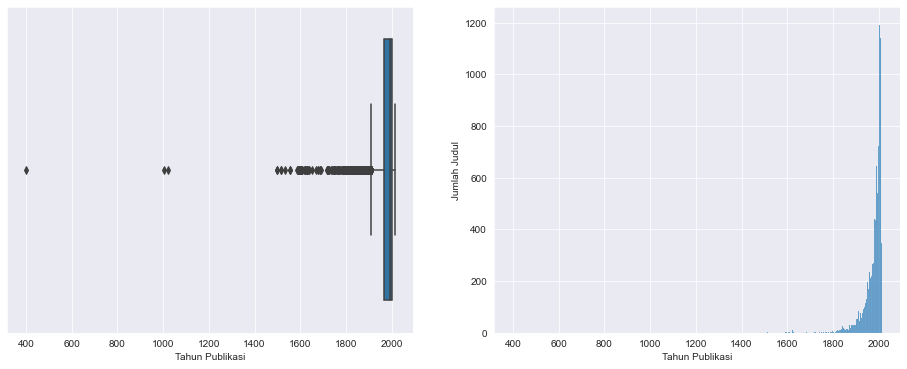

In [137]:
df['publication_year'] = df['publication_date'].str[0:4].astype(float)

df.drop('publication_date', axis = 1, inplace = True)

display_df(df[df['publication_year'].notnull()].drop_duplicates('freebase_ID'))

hist_boxplot(df.drop_duplicates('freebase_ID')['publication_year'], 
             xlabel = 'Tahun Publikasi', ylabel = 'Jumlah Judul')

**_Extreme outliers_ dari tahun publikasi cukup masuk akal selain perlunya koreksi tahun untuk The Wizard of London.**

Cerita-cerita yang lain tersebut memang merupakan cerita klasik dari tahun-tahun yang disebutkan, kecuali The Wizard of London yang seharusnya dari tahun [2005](https://en.wikipedia.org/wiki/Elemental_Masters) dan langsung dikoreksi.

In [138]:
df[df['publication_year'] < 1200].drop_duplicates('freebase_ID')

,wikipedia_ID,freebase_ID,title,author,genre_ID,genre,summary,publication_year
1162,145429,/m/012gzc,The Tale of Genji,Murasaki Shikibu,/m/02xlf,Fiction,The work recounts the life of a son of the Ja...,1021.0
3633,621399,/m/02xk96,The Confessions of St. Augustine,Augustine of Hippo,/m/05h83,Non-fiction,The work outlines Augustine's sinful youth an...,398.0
26210,14773258,/m/03gxjgm,The Wizard of London,Mercedes Lackey,/m/014dfn,Speculative fiction,As an acting prequel to the Elemental Masters...,1005.0


In [139]:
correction_filter = (df['title'] == 'The Wizard of London') & (df['publication_year'] == 1005)

df.loc[correction_filter, 'publication_year'] = 2005

df[correction_filter].head()

,wikipedia_ID,freebase_ID,title,author,genre_ID,genre,summary,publication_year
26210,14773258,/m/03gxjgm,The Wizard of London,Mercedes Lackey,/m/014dfn,Speculative fiction,As an acting prequel to the Elemental Masters...,2005.0
26211,14773258,/m/03gxjgm,The Wizard of London,Mercedes Lackey,/m/01hmnh,Fantasy,As an acting prequel to the Elemental Masters...,2005.0


#### **Duplicate Check**

**Data ini memiliki banyak duplikat untuk mengakomodasi informasi genre.**

Terlihat dari awal bahwa kolom seringkali duplikat berkali-kali dengan isi yang persis sama kecuali untuk genrenya.

In [140]:
assert df.duplicated(keep = False).sum() == 0

df.head()

,wikipedia_ID,freebase_ID,title,author,genre_ID,genre,summary,publication_year
0,620,/m/0hhy,Animal Farm,George Orwell,/m/016lj8,Roman à clef,"Old Major, the old boar on the Manor Farm, ca...",1945.0
1,620,/m/0hhy,Animal Farm,George Orwell,/m/06nbt,Satire,"Old Major, the old boar on the Manor Farm, ca...",1945.0
2,620,/m/0hhy,Animal Farm,George Orwell,/m/0dwly,Children's literature,"Old Major, the old boar on the Manor Farm, ca...",1945.0
3,620,/m/0hhy,Animal Farm,George Orwell,/m/014dfn,Speculative fiction,"Old Major, the old boar on the Manor Farm, ca...",1945.0
4,620,/m/0hhy,Animal Farm,George Orwell,/m/02xlf,Fiction,"Old Major, the old boar on the Manor Farm, ca...",1945.0


**Akan diciptakan dua set DataFrame untuk mengurangi duplikasi ini.**

Satu DataFrame akan berisi data per judul buku tanpa duplikasi genre, dan satu DataFrame khusus untuk menyimpan data genre buku saja.

In [141]:
genre_df = df[['freebase_ID', 'genre', 'genre_ID']].copy()

df = df.drop(['genre', 'genre_ID'], axis = 1).drop_duplicates().reset_index(drop = True)

assert df.duplicated(keep = False).sum() == 0

display_df(genre_df)
display_df(df)

,freebase_ID,genre,genre_ID
0,/m/0hhy,Roman à clef,/m/016lj8
1,/m/0hhy,Satire,/m/06nbt
2,/m/0hhy,Children's literature,/m/0dwly
3,/m/0hhy,Speculative fiction,/m/014dfn
4,/m/0hhy,Fiction,/m/02xlf


(33722, 3)

,wikipedia_ID,freebase_ID,title,author,summary,publication_year
0,620,/m/0hhy,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",1945.0
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",1962.0
2,986,/m/0ldx,The Plague,Albert Camus,The text of The Plague is divided into five p...,1947.0
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,The argument of the Enquiry proceeds by a ser...,NaN
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,NaN


(16559, 6)

#### **Missing Values Check**

**Terdapat missing values pada kolom `author`, `publication_year`, serta kolom seputar genre.**

Untungnya, kekosongan bukan pada kolom utama kali ini, yakni kolom summary dan judul buku.

In [142]:
print('Persentase Missing Value Per Kolom:')

print('\n')

print('DataFrame Utama')
print((df.isnull().mean() * 100).round(2))

print('\n')

print('DataFrame Genre')
print((genre_df.drop_duplicates('freebase_ID').isnull().mean() * 100).round(2))

Persentase Missing Value Per Kolom:


DataFrame Utama
wikipedia_ID         0.00
freebase_ID          0.00
title                0.00
author              14.38
summary              0.00
publication_year    33.88
dtype: float64


DataFrame Genre
freebase_ID     0.00
genre          22.45
genre_ID       22.45
dtype: float64


##### Pengisian Missing Values Umum

**Missing values akan diisi apabila waktu mencukupi untuk mengambil data dari Wikidata.**

Ketiga kolom yang kosong sebenarnya dapat diisi (_to a certain extent_) dengan mengambil dari sumber data yang tersedia, yaitu dari Freebase (sekarang dihosting oleh Wikidata) atau dari Wikipedia untuk summary buku.

Namun, karena keterbatasan waktu dan jumlah data yang perlu diambil, data akan diisi hanya jika waktunya cukup saja, dengan kode utama pengambilan dapat dilihat di bawah ini.

In [143]:
#import sys
#from SPARQLWrapper import SPARQLWrapper, JSON

# def fetch_metadata(metadata_type, freebase_ID):
#   '''
#        Get the metadata needed to fill missing values in this data, one at a time
#        (Most of the code is modified from Wikidata SPARQL code generator)
#    '''

#    wikidata_dict = {
#        'author': 'P50',
#        'publication_date': 'P577',
#        'genre': 'P136'
#    }

#    endpoint_url = "https://query.wikidata.org/sparql"

#    query = """SELECT ?s ?sLabel ?p ?o ?oLabel WHERE {
#      ?s ?p ?o;
#        wdt:P646""" + '"' + freebase_ID + '"' + """;
#        wdt:""" + wikidata_dict[metadata_type] + """ ?o.
#      SERVICE wikibase:label { bd:serviceParam wikibase:language""" + '"en"' + """. }
#    }"""

#    def get_results(endpoint_url, query):
#        user_agent = 'WDQS-example Python/%s.%s' % (sys.version_info[0], sys.version_info[1])
#        sparql = SPARQLWrapper(endpoint_url, agent = user_agent)
#        sparql.setQuery(query)
#        sparql.setReturnFormat(JSON)
#        return sparql.query().convert()

#    results = get_results(endpoint_url, query)
    
#    try:
#        if metadata_type != 'genre':
#            result = results['results']['bindings'][0]
#            return result['oLabel']['value']

#        else:
#            results = results['results']['bindings']
#            return [result['oLabel']['value'] for result in results]
#    except:
#        return np.nan

**Di bawah ini adalah pengisian berdasarkan tambahan data yang telah diambil dari WikiData di notebook lain.**

Data telah diambil pelan-pelan selama berjam-jam dan akan digunakan untuk kolom `author` dan `publication_date`. 

In [144]:
def wikidata_fill(df, column):
    '''
        If the feather file containing the replacement values exists, 
        fill in missing values in the main DataFrame with it.
    '''
    original_columns = df.columns
    original_sort = df['freebase_ID']
    
    new_column = 'new_' + column
    
    wikidata_df = pd.read_feather(f'{column} filler.feather').\
        rename(columns = {column: new_column})
    
    if column == 'publication_date':
        column = 'publication_year'
        
        wikidata_df[new_column] = wikidata_df[new_column].\
            str.extract('(^(?:\-)?\d{4})')[0].astype(float)
        
        new_column = 'new_' + column
        wikidata_df.rename(columns = {'new_publication_date': new_column}, inplace = True)
        
    df = df.merge(wikidata_df, how = 'left', on = 'freebase_ID')
    
    fill_filter = df['freebase_ID'].isin(wikidata_df['freebase_ID']) == True
    
    # Can't assign using numpy arrays with missing values
    df.loc[fill_filter, column] = df.loc[fill_filter, new_column].fillna('placeholder')
    df[column] = df[column].replace('placeholder', np.nan)
    
    df.drop_duplicates(inplace = True)
    df.drop(new_column, axis = 1, inplace = True)
    
    return df.reset_index()[original_columns]

**Data utama menjadi jauh lebih lengkap dengan data penulis dan tanggal yang baru.**

Data menjadi jauh lebih mungkin digunakan dengan jumlah persentase sekitar ~10% dibandingkan sebelumnya.

In [145]:
df = wikidata_fill(df, 'author')
df = wikidata_fill(df, 'publication_date')

print('Persentase Missing Value Per Kolom:')

print('\n')

print('DataFrame Utama')
print((df.isnull().mean() * 100).round(2))

Persentase Missing Value Per Kolom:


DataFrame Utama
wikipedia_ID         0.00
freebase_ID          0.00
title                0.00
author               5.73
summary              0.00
publication_year    11.45
dtype: float64


**Intermezzo: Jumlah unique author kita bertambah drastis!**

Dari awalnya sekitar ~4,700 author, kini kita ada ~850 author lebih banyak daripada sebelumnya. Pengisian missing data! 

In [146]:
print(f"Jumlah unique author: {count_unique(df['author'])}")

Jumlah unique author: 5577


**Missing value yang tersisa di author tidak akan kita isi** meskipun hanya sisa sedikit, karena pengisian modus untuk data dengan variasi sebanyak ini agak kurang cocok. Data author hanya dipakai untuk pelengkap eksplorasi hasil clustering nanti saja.

**Intermezzo: Sebagian besar buku dipublikasi setelah pertengahan abad ke-20.**
    
Sebagian besar buku dalam koleksi kita ternyata buku-buku yang relatif baru! Dapat dilihat ada beberapa buku di bawah 1000 Masehi. 

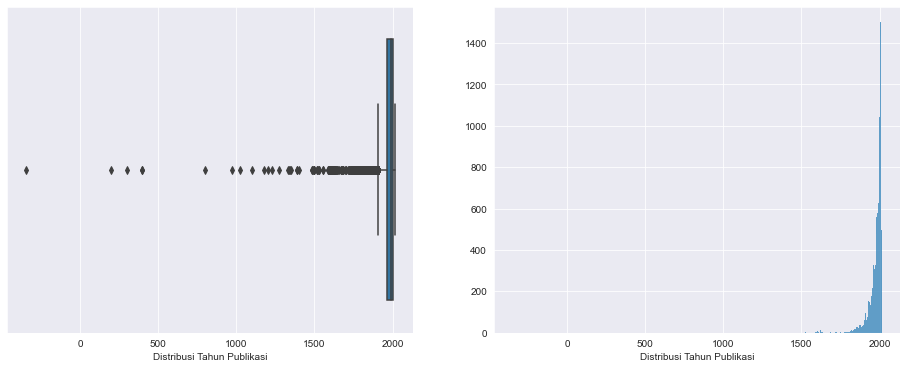

Summary statistik dari tahun publikasi:
count    14663.000000
mean      1972.829366
std         64.184951
min       -348.000000
25%       1964.000000
50%       1990.000000
75%       2003.000000
max       2013.000000
Name: publication_year, dtype: float64


In [147]:
hist_boxplot(df['publication_year'], xlabel = 'Distribusi Tahun Publikasi')

print('Summary statistik dari tahun publikasi:')
print(df['publication_year'].describe())

Apakah itu outlier? Hasil pengecekan menunjukkan bahwa data tahun publikasi kita memang benar. Faktanya, memang ada buku kita yang dipublikasi 348 SM!

In [55]:
df[df['publication_year'] < 1000].sort_values('publication_year')

,wikipedia_ID,freebase_ID,title,author,summary,publication_year
1319,591767,/m/02t6n6,Nicomachean Ethics,Aristotle,Aristotle argues that the correct approach in...,-348.0
2794,1663256,/m/05lnj6,Agricola,Tacitus,"After the assassination of Domitian in 96AD, ...",200.0
6857,5738625,/m/02p9q0s,Aethiopica,Heliodorus of Emesa,"Chariclea, the daughter of King Hydaspes and ...",300.0
5588,4502005,/m/0c5v3w,On Christian Doctrine,Augustine of Hippo,The Prologue consists of a response to who wo...,397.0
1381,621399,/m/02xk96,The Confessions of St. Augustine,Augustine of Hippo,The work outlines Augustine's sinful youth an...,398.0
14097,23070506,/m/064lrhz,Vita Sancti Wilfrithi,Stephen of Ripon,The Vita narrates the life and career of Wilf...,800.0
11321,14741883,/m/03gw87k,Kagerō Nikki,Michitsuna no Haha,Kagerō Nikki focuses on the development of Mo...,974.0


**Secara per dekade, koleksi buku terbanyak berasal dari periode 1970-2010.**

Menggunakan binning membuat distribusi buku menjadi lebih terlihat. Pemilik toko terutama memiliki banyak buku dari tahun 2000-an (tidak termasuk buku yang _missing_ tahun publikasinya).

In [148]:
# Ini cara membuat bins periode yang akurat 
# (membuat ex: 2010, 2020 justru akan berakhir berbeda)
year_bins = pd.IntervalIndex.from_tuples([(-500, 499), (499, 999), (999, 1249), 
                                          (1249, 1499), (1499, 1749), (1749, 1899), 
                                          (1899, 1949), (1949, 1969), (1969, 1979),
                                          (1979, 1989), (1989, 1999), 
                                          (1999, 2009), (2009, 2020)])
year_labels = ['< 500', '500-1000', '1000-1250', '1250-1500', '1500-1750', '1750-1900', 
               '1900-1950', '1950-1970', '1970s', '1980s', '1990s', '2000s', '2010s']

publication_period = pd.cut(df['publication_year'], year_bins)

publication_period.cat.categories = year_labels

display_df(df)

,wikipedia_ID,freebase_ID,title,author,summary,publication_year,publication_period
0,620,/m/0hhy,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",1945.0,1900-1950
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",1962.0,1950-1970
2,986,/m/0ldx,The Plague,Albert Camus,The text of The Plague is divided into five p...,1947.0,1900-1950
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,The argument of the Enquiry proceeds by a ser...,1748.0,1500-1750
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,1992.0,1990s


(16559, 7)

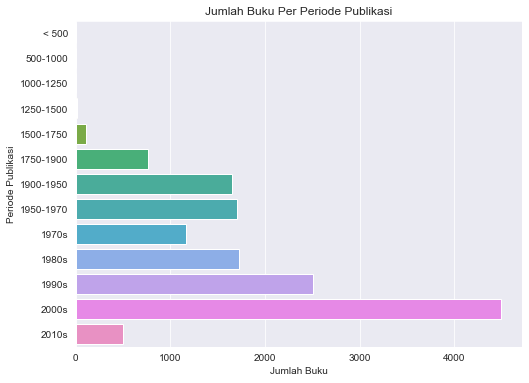

In [154]:
plt.figure(figsize = (8, 6))

sns.countplot(y = publication_period).\
    set(xlabel = 'Jumlah Buku', ylabel = 'Periode Publikasi', 
        title = 'Jumlah Buku Per Periode Publikasi')

plt.show()

**Data tahun publikasi diisi dengan median dan dapat digunakan untuk seterusnya!**

Data tahun publikasi akan diisi dengan median alih-alih dengan rata-rata karena outlier yang cukup signifikan dalam kolom ini. Seperti summary statistik sebelumnya, terdapat 34 tahun selisih antara median dan rata-rata, yang cukup signifikan mengingat betapa dekatnya tahun-tahun publikasi kita.

In [56]:
df['publication_year'] = df['publication_year'].fillna(df['publication_year'].median())

print('Persentase Missing Value Per Kolom Setelah Pengisian:')

print('\n')

print('DataFrame Utama')
print((df.isnull().mean() * 100).round(2))

Persentase Missing Value Per Kolom Setelah Pengisian:


DataFrame Utama
wikipedia_ID        0.00
freebase_ID         0.00
title               0.00
author              5.73
summary             0.00
publication_year    0.00
dtype: float64


##### Missing Values Summary Buku

**...Sebenarnya, ada "missing values" dalam summary buku yang tidak tampil dengan pengecekan biasa.**

Seperti hasil EDA sebelumnya, seringkali summary dengan panjang summary di bawah 8 kata kurang bermakna, bahkan dapat dikatakan sebenarnya adalah missing values. Oleh karena itu, summary-summary ini perlu dikoreksi.

In [57]:
display_df(dedup_df[summary_len < 8])

,wikipedia_ID,freebase_ID,title,author,publication_date,genre_ID,genre,summary,summary_length,cleaner_summary
5264,1078455,/m/0442g7,The Kennel Murder Case,S. S. Van Dine,NaN,/m/02n4kr,Mystery,~Plot outline description,3,plot outlin descript
9587,2664992,/m/07wd73,Slavers,Chris Pramas,2000,/m/06c9r,Role-playing game,==Publication histor,2,public histor
9946,2832333,/m/085kz9,Deathstalker,Simon Green,NaN,/m/06n90,Science Fiction,- --&#62; &#60;!-,2,62 60
12663,4118477,/m/0bk2zx,Golem in the Gears,Piers Anthony,1986-02,/m/06n90,Science Fiction,pl:Zakochany golem,3,pl zakochani golem
13463,4507859,/m/0c63m2,The Adventures of Super Diaper Baby,Dav Pilkey,2002,/m/0dwly,Children's literature,=== Plot summary ===,2,plot summari


(50, 10)

**Summary buku di bawah 8 kata dikoreksi secara manual dengan menggunakan genre + judul atau sumber-sumber summary lainnya.**

Karena jumlah bukunya masih relatif banyak, buku-buku yang memiliki genre akan dikoreksi dengan menggabungkan judul dan genrenya untuk dijadikan sebagai pengisi summary.

In [58]:
missing_summary_list = dedup_df.loc[summary_len < 8, 'freebase_ID']

# Get which titles are missing in the main DataFrame first
summary_filter = df['freebase_ID'].isin(missing_summary_list)
missing_df = df.loc[summary_filter, ['freebase_ID', 'title']]

# Generate the values with which we will fill the missing values
missing_df_genre = genre_df[genre_df['freebase_ID'].isin(missing_summary_list)]
summary_filler = missing_df_genre.fillna('')

summary_filler = summary_filler.groupby('freebase_ID')['genre'].\
    agg(lambda x: ' '.join(x)).reset_index().rename(columns = {'genre': 'summary'})

summary_filler = summary_filler.merge(missing_df, how = 'left', on = 'freebase_ID').\
    set_index('freebase_ID')

summary_filler['summary'] = summary_filler['summary'] + ' ' + summary_filler['title']

# Fill the original df with the created fillers
df.loc[summary_filter, 'summary'] = summary_filler.\
    loc[df.loc[summary_filter, 'freebase_ID'], 'summary'].tolist()

display_df(df[summary_filter])

,wikipedia_ID,freebase_ID,title,author,summary,publication_year
2045,1078455,/m/0442g7,The Kennel Murder Case,S. S. Van Dine,Mystery Fiction Suspense The Kennel Murder Case,1933.0
3879,2664992,/m/07wd73,Slavers,Chris Pramas,Role-playing game Slavers,2000.0
4045,2832333,/m/085kz9,Deathstalker,Simon Green,Science Fiction Speculative fiction Deathstalker,1990.0
5271,4118477,/m/0bk2zx,Golem in the Gears,Piers Anthony,Science Fiction Speculative fiction Fantasy Fi...,1986.0
5595,4507859,/m/0c63m2,The Adventures of Super Diaper Baby,Dav Pilkey,Children's literature The Adventures of Super ...,2002.0


(50, 6)

Apabila tidak ada genre, barulah buku tersebut benar-benar diisi manual dari berbagai sumber. Sumber yang digunakan: Google Books, Wikipedia, Goodreads, website penulis, Korea Literature Translation Institute ketika dibutuhkan.

In [59]:
missing_summary_list = missing_df_genre.\
    loc[missing_df_genre['genre'].isnull(), 'freebase_ID']

summary_filter = df['freebase_ID'].isin(missing_summary_list)
missing_df = df.loc[summary_filter, ['freebase_ID', 'title']]

missing_df

,freebase_ID,title
8487,/m/0273rt5,No Place for Grubbs!
13316,/m/051vzd7,Clara Vaughan
13381,/m/051_2c7,Beyond Thirty and The Man-Eater
15767,/m/0g5sy0d,Alice Lorraine
15958,/m/0gj9g4m,Flame
16002,/m/0gkzw5g,The Case of the Cursed Clock
16161,/m/0gvsdvm,The Oakdale Affair and The Rider
16172,/m/0gx1hm1,A Matter of Death and Life


In [60]:
summary_dict = {
    'No Place for Grubbs!': "Charles Grubb is very tidy. But his parents are grubs. Real grubs. They practise forward-rolls down the hallway, they never do the washing up, they dance instead of dust and they collect tonnes and tonnes of useless junk. So Charles embarks on a campaign to clean up his parents. It's a very, very tough job...", 
    'Clara Vaughan': "Clara Vaughan, which takes place in the mid-19th century, is the story of the eponymous heroine, an only child whose father is mysteriously murdered when she is a young girl. As a young woman, she sets out to uncover the identity of her father's killer, and for this reason the novel is often classed among the first detective novels in English. In addition to this overarching theme, there are several sub-plots involving family secrets, romances, and questions of familial inheritance.", 
    'Beyond Thirty and The Man-Eater': "Beyond Thirty. The story was heavily influenced by the events of World War I, and reflects U.S. sentiments at the time of writing. When the war broke out, Americans were predominantly isolationist and wary of being drawn into a European war. Burroughs imagines a future two centuries onward in which that view prevailed and the western hemisphere severed contact with the rest of the world. Consequently, the eastern hemisphere has exhausted itself in war and Europe descended into barbarism while the Americas, sheltered from the destruction, have continued to advance and joined peacefully into the union of Pan-America. By the twenty-second century the entire world east of the 30th meridian west and west of the 175th meridian east has become terra incognita to Pan-America. In 2137, Pan-American Navy Lieutenant Jefferson Turck is commander of the aero-submarine Coldwater, tasked with patrolling the 30th meridian from Iceland to the Azores. Disaster strikes when the vessel's anti-gravitation screens fail, dooming it to wallow upon the surface of the ocean, and the engines fail, leaving it adrift. As its wireless radio has failed as well, Turck cannot even summon help. It is implied that the perfidy of the Coldwater’s second officer is behind its misfortunes, as well as the abandonment at sea of Turck and three crewmen in a small boat while attempting repairs. Adrift, Turck and his companions are forced to make shore in forbidden England. Turck falls into the hands of raiders from the Abyssinian Empire, a black super-state ruling all of Africa, most of Europe, and the Arabian peninsula. While the Abyssinians' technology is roughly equivalent to that of the nineteenth century, the white savages that populate Europe in Turck’s time are no match for them. The Abyssinians consider whites a lower order and take them as slaves. Turck too is pressed into slavery. Becoming the personal servant of an Abyssinian colonel he is treated better than many of his fellow slaves, but is rankled by his status. Turck's master takes him to the court of the Abyssinian Emperor, Menelek XIV. Menelek is portrayed as gross and cruel, perhaps once a great man, but now corrupted by power. Turck watches powerless as white slave women are offered to the emperor for his harem, including the heroine Victory, queen of the primitives of England. Eventually Turck succeeds in rescuing Victory and makes his way with her to the rival empire of China. Communications between the hemispheres are re-opened, with commerce to follow, and Turck, despite violating the edict against crossing the 30th meridian, is hailed as a hero in Pan-America. The Man-Eater. Jefferson Scott, Jr. and Robert Gordon, hunters in the Belgian Congo, are thrown together with missionaries Sangamon and Mary Morton and their daughter Ruth. Scott marries Ruth, and Gordon is entrusted with stock certificates to be taken back to Scott's father in America. Later Scott and the elder Mortons are killed by the native Wakandas; Ruth and her daughter Virginia are saved by Belgian forces and afterwards return to America to live with Scott's father. The stock certificates, meanwhile, have gone astray, with only a single sheet of paper having been delivered to the elder Scott. Nineteen years pass. On the death of Jefferson Scott, Sr., Virginia Scott is to inherit the estate, but the will cannot be located, and Scott Taylor, her grandfather’s disinherited nephew, appears to claim a half share. Proposing to Virginia in an effort to obtain it all, he is rebuffed, whereupon he disputes her right to any of the estate, pretending she is illegitimate. Ruth attempts to prove her marriage to Virginia's father by writing to Robert Gordon, who witnessed the ceremony, but he is now deceased. Her appeal reaches his son Dick Gordon instead. Moved but unable to provide the desired proof, Gordon writes back of his intention to sail to Africa to seek documentation of the marriage there. Taylor intercepts the letter and follows him with the intention of murder. Discovering this, Virginia also sets out for Africa. Gordon reaches the ruins of the old mission and finds there a sealed envelope, with which he begins his trek back to the coast. Taylor and his confederates Kelley and Gootch await him in ambush in a native village. They kill a lioness, whose mate the natives take captive in a pit trap. Virginia arrives at the village and is imprisoned by the villains. Meanwhile, Gordon discovers and frees the captured lion, which then returns to the village seeking the killers of its mate. The lion arrives just as the villains are about to rape and kill Virginia, and kills Gootch while others flee. Virginia escapes but is stalked by a hyena. Gordon, who happens to be nearby, hears her scream and shoots the beast. She warns him against Taylor, who then appears with Kelley, seeking her. Seizing Gordon’s gun, she wounds Taylor and drives the villains off. They return to America and separate, Gordon somehow neglecting to give her the envelope. Meanwhile, the lion has been captured by hunters and sold to an itinerant American circus, in which he is billed as 'Ben, King of Beasts, the Man-Eating Lion.' Realizing his omission, Gordon visits the Scott home to deliver the envelope to Virginia and Ruth, unaware that Taylor and Kelley have returned from Africa and still plan to kill him. He finds the Scotts absent from home, their return delayed by a train wreck. Ben, who was also on the train, is freed by the wreck and turns up at the house, where he detects the scents of both his rescuer Gordon and the two villains. Encountering the latter, he kills Kelley and pursues Taylor to Gordons room. There Taylor struggles with Gordon and overcomes him, taking the envelope before fleeing from Ben. The lion follows, overtaking and killing Taylor within sight of the returning Scott's. Gordon, pursuing Taylor, recognizes Ben and protects him from the armed party that arrives to kill the escaped lion. He buys Ben from the circus, intending to give him a new home in a zoo. The mysterious envelope, finally opened, proves to contain the long lost stocks, not the hoped for marriage certificate. The latter turns up, together with the missing will, in a cupboard in the Scott house, having been secreted there by Jefferson Scott, Sr. The certificate was evidently the paper Gordon's father had delivered to the elder Scott instead of the stocks. Dick Gordon and Virginia Scott declare their love for each other and decide to marry.",
    'Alice Lorraine': "The story is set in the early years of the 19th century. The hero and heroine, brother and sister, are children of Sir Roland Lorraine, representative of a very ancient family. Hilary, while studying for the bar in London, falls in love with the daughter of a Kentish farmer, the sister of his fellow-pupil. He confesses his folly to his father, who at once buys for him a commission in a regiment of foot on service in Spain. The young man distinguishes himself at Badajos, and is on the high road to fame, when he falls under the spell of a Spanish countess, and forgets for a time his promise to the Kentish girl. Through the countess's treachery he loses £50,000, military funds, with which he is entrusted, and leaves the army. Meantime his sister has been fighting a severe battle at home—defending herself against a plot to make her the wife of a drunken fellow named Chapman. Hilary comes home; Mabel, the Kentish girl, is sent for, and matters are serene with all but Alice on the day appointed for her wedding. When the hour for the ceremony approaches, she walks out and throws herself into the river, is carried a mile, rescued and resuscitated.", 
    'Flame': "Behavioral humanism, or the expression of an active will in dire situations, characterizes Sunwoo Hwi’s literary world. “Flowers of Fire” (Bulkkot), for which he first gained recognition, features a man who overcomes his escapist mentality to embrace the spirit of resistance. As revealed in “Flowers of Fire” as well as in the novels Flagman Without a Flag (Gitbal eomneun gisu) and The Finale of the Chase (Chujeogui pinalle), the will to act is rooted in respect for mankind and desire to oppose dehumanization. For Sunwoo Hwi, the responsibility of intellectuals includes active participation in the affairs of the society and resistance to dehumanization caused by ideological conflicts and social ills. The humanistic approach, however, is overemphasized in works such as Myth of Bush-clover Village (Ssaritgorui sinhwa), giving the work the feel of an imaginary world removed from contemporary reality. After 1965, Sunwoo Hwi began to evince a more conservative attitude towards the establishment. “Golgotha Without Cross” (Sipjaga eomneun golgoda), “A Thirteen-Year-Old Boy” (Yeol sesarui sonyeon) and “A Funny Story About Funny People” focus on nostalgia for lost childhood homes, and The Jackpot (Nodaji), serialized in Chosun Weekly from 1979 to 1981, is a family chronicle.", 
    'The Case of the Cursed Clock': "Turn off your lights, get ready for frights! When the clock strikes midnight and the moon's full and bright, it's time for dread and fear. For Mr. Midnight is here with two stories, double the danger and twice the terror! The danger keeps ticking. Can Johnson Wee and his friends solve The Case of the Cursed Clock - before the world runs out of time? Evil green burgers from another planet? Will Elise and her girls escape the horrors of the Night of the Haunted Hamburgers? Find out!", 
    'The Oakdale Affair and The Rider': "The Oakdale Affair. The beautiful young daughter of a wealthy family is robbed of her money and jewels, and she herself disappears soon after… A young man fleeing a band of murderous hobos becomes the target of a lynch mob… Frozen to silent rigidity, they sat straining every faculty to catch the minutest sound from the black void where the dead man lay. As they listened there came up to them, mingled with inexplicable footsteps, a hollow reverberation from the dank cellar- a hideous dragging of chains behind the nameless horror which had haunted them through the interminable eons of the ghastly night. Up, up it came toward the room at the head of the stairs where they huddled fearfully. They could now hear quite clearly what might have been the slow and ponderous footsteps of a heavy man dragging painfully across the rough floor . It stopped in front of their hideout and all was silent. Suddenly there rang out against the silence of the awful night a piercing shriek, and a great The Oakdale Affair force began to bend the flimsy door…. The Rider. Karlova and Margoth had been enemies for centuries-and now they were about to join in peaceful alliance through the marriage of Princess Mary and Prince Boris. But the Rider, the most successful highwayman ever to plague the two countries, secretly became part of the royal wedding plans. From then on, nothing went according to schedule. Who was this mysterious brigand? What could he gain by sabotaging the two nations’ only chance for peace? Where a dirt road leaves the old Roman road just within the foothills, the Crown Prince Boris of Karlova entered the gloomy precincts of the wood. He rode slowly, as a walk was the only gait possible along the black and winding path. He had covered perhaps half the distance between the Roman road and Peter’s inn when a figure loomed suddenly ahead of him-a tall man, the upper half of his face hidden beneath a black mask, upon a large horse blocking the way. “Who the devil are you?” he grinned as he pointed the barrel of his villainous revolver straight at the Prince’s breast….", 
    'A Matter of Death and Life': "The narrator of the story is going through a difficult phase in life. His marriage is collapsing, it appears that his wife is having an affair with someone, he is unemployed, his bank balance is low, he doesn't seem to have any friends. One day he decides to do something which he thinks will be spectacular. He decides to hire a hitman to kill him. He makes arrangements and is resigned to his fate, and thinks about how he will be in the news when it happens and he'll become famous and people will look at him differently. But at some point things start looking up, and he even finds some happiness and he doesn't want to die anymore. But how do you stop a hitman from executing his contract? Not possible, isn't it? What happens after that is darkly comic and unravels like a Coen Brothers movie."
}

summary_filler = missing_df.\
    merge(pd.DataFrame({'title': summary_dict.keys(),
                        'summary': summary_dict.values()})).\
    set_index('freebase_ID')
    
df.loc[summary_filter, 'summary'] = summary_filler.\
    loc[df.loc[summary_filter, 'freebase_ID'], 'summary'].tolist()

display_df(df[summary_filter])

,wikipedia_ID,freebase_ID,title,author,summary,publication_year
8487,8448160,/m/0273rt5,No Place for Grubbs!,<NA>,Charles Grubb is very tidy. But his parents ar...,1998.0
13316,20546495,/m/051vzd7,Clara Vaughan,R. D. Blackmore,"Clara Vaughan, which takes place in the mid-19...",1864.0
13381,20710665,/m/051_2c7,Beyond Thirty and The Man-Eater,Edgar Rice Burroughs,Beyond Thirty. The story was heavily influence...,1957.0
15767,30468411,/m/0g5sy0d,Alice Lorraine,R. D. Blackmore,The story is set in the early years of the 19t...,1875.0
15958,31219389,/m/0gj9g4m,Flame,Sunwoo Hwe,"Behavioral humanism, or the expression of an a...",1957.0


(8, 6)

##### Menghapus kolom-kolom yang tidak diiisi dan digunakan

**Awalnya, kolom `author` dan `publication_year` akan dihapus, tetapi setelah diisi tidak jadi dihapus!**

Di bawah ini adalah tulisan dan kode asli apabila kedua kolom itu tidak berhasil diisi.

Kolom-kolom yang masih kosong hingga kini dirasa memiliki persentase kekosongan yang terlalu besar untuk digunakan, sehingga akan dihapus dari data.

Untungnya, tugas ini memang semestinya berfokus pada summary buku. Note: Penghapusan lebih berfokus pada DataFrame utama yang akan dipakai, yang disimpan sebagai `df`.

In [61]:
# print('Persentase Missing Value Per Kolom:')

# print('\n')

# print('DataFrame Utama')
# print((df.isnull().mean() * 100).round(2))

In [62]:
# df.drop('publication_year', axis = 1, inplace = True)

# print('Info DataFrame Utama')
# df.info()

#### **Miscellaneous Correction**

**Sesuai dengan EDA sebelumnya, koreksi untuk genre ID Misteri akan dilakukan.**

Sebelumnya, ditemukan bahwa genre misteri terdaftar dengan dua ID genre. Salah satu ID genre dirasa lebih valid, sehingga ID genre itu akan digunakan untuk genre misteri seterusnya.

In [63]:
genre_df.loc[genre_df['genre'] == 'Mystery', 'genre_ID'] = '/m/0fq56vk'

genre_df.loc[genre_df['genre'] == 'Mystery', 'genre_ID'].drop_duplicates()

63    /m/0fq56vk
Name: genre_ID, dtype: string

### **Preprocessing NLP**

#### **Lower Casing**

Untuk menyamakan kapitalisasi setiap tulisan agar mudah dikenali dan diproses komputer seterusnya.

**Semua kata dalam summary diubah menjadi huruf kecil.**

Antara menjadi huruf besar semua atau menjadi huruf kecil semua, penulis memiliki preferensi lebih kepada huruf kecil.

In [64]:
df['clean_summary'] = df['summary'].str.lower()

display_df(df)

,wikipedia_ID,freebase_ID,title,author,summary,publication_year,clean_summary
0,620,/m/0hhy,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",1945.0,"old major, the old boar on the manor farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",1962.0,"alex, a teenager living in near-future englan..."
2,986,/m/0ldx,The Plague,Albert Camus,The text of The Plague is divided into five p...,1947.0,the text of the plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,The argument of the Enquiry proceeds by a ser...,1748.0,the argument of the enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,1992.0,the novel posits that space around the milky ...


(16559, 7)

#### **Pembersihan Pattern/Symbol**

Untuk menghilangkan noise-noise yang sebenarnya tidak terkait dengan konten asli yang kita perlukan.

**Dua versi summary akan dibuat dalam pembersihan noise.**

<u>Berbagai noise berupa pattern atau symbol dalam summary akan dihapus agar hasil summary semakin baik.</u> Hal ini termasuk tanda baca, HTML tag, URL dan protokol URL, coretan-coretan lain yang nampaknya umum ada dalam data, serta kelebihan spasi baik di depan, tengah, maupun belakang.

<u>Dua versi akan dibuat:</u> satu untuk kolom `clean_summary` yang akan dibersihkan seterusnya, dan satu untuk kolom baru `noiseless_summary` yang dibuat khusus untuk hanya dibersihkan noisenya saja, untuk salah satu feature engineering nanti.

In [65]:
noise_patterns = [r'<.*?>', # HTML tag detector
                  r'(http|ftp)(s)?://\S+', # http(s) detector
                  r'www\.\S+', # www detector
                  r'\w+\.\w+\/\w+\/(\S+)?', # Another URL detector
                  r'\={2,}\S+( \S+$)?', # ex: ==Characters
                  r'-?-?\&\#62;', # HTML comment 
                  r'&#60;!?-?', # HTML comment too
                  r'~?plot outline description~?', # An oddity in the data
                  r'to be added\.' # Another oddity in the data
                 ]

for pattern in noise_patterns:
    df['clean_summary'] = df['clean_summary'].\
        str.replace(pattern, '', regex = True) # already lower case
    df['noiseless_summary']= df['summary'].\
        str.replace(pattern, '', regex = True, case = False)

# All symbols except aposthrope (English-specific)    
punctuation_regex = r"[^\w\s\']" 

df['clean_summary'] = df['clean_summary'].\
    str.replace(punctuation_regex, ' ', regex = True).\
    str.replace('  +', ' ', regex = True).str.strip()

df['noiseless_summary'] = df['noiseless_summary'].\
    str.replace(punctuation_regex, ' ', regex = True).\
    str.replace('  +', ' ', regex = True).str.strip()

display_df(df)

,wikipedia_ID,freebase_ID,title,author,summary,publication_year,clean_summary,noiseless_summary
0,620,/m/0hhy,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",1945.0,old major the old boar on the manor farm calls...,Old Major the old boar on the Manor Farm calls...
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",1962.0,alex a teenager living in near future england ...,Alex a teenager living in near future England ...
2,986,/m/0ldx,The Plague,Albert Camus,The text of The Plague is divided into five p...,1947.0,the text of the plague is divided into five pa...,The text of The Plague is divided into five pa...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,The argument of the Enquiry proceeds by a ser...,1748.0,the argument of the enquiry proceeds by a seri...,The argument of the Enquiry proceeds by a seri...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,1992.0,the novel posits that space around the milky w...,The novel posits that space around the Milky W...


(16559, 8)

#### **Tokenisasi**

Untuk memecah summary menjadi daftar kata-kata, dan menyiapkan untuk langkah-langkah preprocessing selanjutnya.

**Summary akan menjalani proses tokenisasi menggunakan library NLTK.**

Tokenizer NLTK dipilih karena dapat diatur agar menggunakan metode bahasa tertentu (dalam kasus ini, bahasa Inggris).

In [66]:
df['clean_summary'] = df['clean_summary'].apply(word_tokenize)

display_df(df)

,wikipedia_ID,freebase_ID,title,author,summary,publication_year,clean_summary,noiseless_summary
0,620,/m/0hhy,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",1945.0,"[old, major, the, old, boar, on, the, manor, f...",Old Major the old boar on the Manor Farm calls...
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",1962.0,"[alex, a, teenager, living, in, near, future, ...",Alex a teenager living in near future England ...
2,986,/m/0ldx,The Plague,Albert Camus,The text of The Plague is divided into five p...,1947.0,"[the, text, of, the, plague, is, divided, into...",The text of The Plague is divided into five pa...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,The argument of the Enquiry proceeds by a ser...,1748.0,"[the, argument, of, the, enquiry, proceeds, by...",The argument of the Enquiry proceeds by a seri...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,1992.0,"[the, novel, posits, that, space, around, the,...",The novel posits that space around the Milky W...


(16559, 8)

#### **Menghilangkan Stopwords**

Untuk menghilangkan kata-kata yang terlalu umum atau kurang bermakna.

**Daftar stopwords dibuat dari daftar stopwords NLTK beserta beberapa kata yang ditemukan dalam EDA.**

Terutama yang akan ditambahkan adalah kata-kata angka, seperti "one" dan "two".

In [67]:
stopwords = list(set(nltk.corpus.stopwords.words('English')))

stopwords = stopwords + ['one', 'two', 'three', 'four', 'five', 
                         'six', 'seven', 'eight', 'nine', 'ten']
sorted(stopwords)

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'eight',
 'few',
 'five',
 'for',
 'four',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'nine',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'one',
 'only',
 'or',
 'other',
 'our',
 'ours

**Stopwords dihilangkan dari daftar kata-kata summary sebelumnya.**

In [68]:
df['clean_summary'] = df['clean_summary'].\
    apply(lambda word_list: [word for word in word_list if word not in stopwords])

display_df(df['clean_summary'])

0    [old, major, old, boar, manor, farm, calls, an...
1    [alex, teenager, living, near, future, england...
2    [text, plague, divided, parts, town, oran, tho...
3    [argument, enquiry, proceeds, series, incremen...
4    [novel, posits, space, around, milky, way, div...
Name: clean_summary, dtype: object

(16559,)

#### **Lemmatization dan Stemming**

Untuk mengubah kata-kata yang sebenarnya berbentuk dasar sama menjadi satu, sehingga mengurangi jumlah kata yang perlu diproses dan mempermudah perbandingan.

**Lemmatization dan Stemming akan dilakukan bersama untuk menghemat waktu iterasi setiap kata.**

Karena sebenarnya sama-sama memproses kata satu per satu, maka keduanya akan dilakukan bersama untuk menghemat _overhead_ menggunakan .apply() diikuti dengan list comprehension. 

Lemmatization dilakukan dengan WordNetLemmatizer, sementara stemming dilakukan dengan SnowballStemmer NLTK, sama-sama dengan setting bahasa Inggris

In [69]:
sb = SnowballStemmer(language = 'english')
lemmatizer = WordNetLemmatizer()

df['clean_summary'] = df['clean_summary'].\
    apply(lambda word_list: [sb.stem(lemmatizer.lemmatize(word)) for word in word_list])

display_df(df['clean_summary'])

0    [old, major, old, boar, manor, farm, call, ani...
1    [alex, teenag, live, near, futur, england, lea...
2    [text, plagu, divid, part, town, oran, thousan...
3    [argument, enquiri, proceed, seri, increment, ...
4    [novel, posit, space, around, milki, way, divi...
Name: clean_summary, dtype: object

(16559,)

#### **Penyimpanan Data**

**Data yang telah dibersihkan akan disimpan dalam bentuk _intermediate_ sebagai feather file.**
Pembersihan data memakan waktu cukup lama, sehingga langsung disimpan agar bisa tidak diulang-ulang lagi!

In [70]:
df.reset_index(drop = True, inplace = True)
df.to_feather('cleaned-nlp.feather')

In [71]:
genre_df.reset_index(drop = True, inplace = True)
genre_df.to_feather('cleaned-genre.feather')

## **Feature Engineering**

In [5]:
df = pd.read_feather('cleaned-nlp.feather')
genre_df = pd.read_feather('cleaned_genre.feather')

**Beberapa pendekatan akan digunakan untuk feature engineering kali ini.**

Feature engineering akan diutamakan dari summary buku sesuai instruksi, diikuti dengan tambahan dari kolom-kolom lainnya yang dapat digunakan.

### **Book Summary Doc2Vec**

**Feature engineering utama dari summary buku akan menggunakan Doc2Vec, yaitu ekstensi dari Word2Vec yang dapat digunakan untuk tingkat dokumen.**

Mengapa Doc2Vec dipilih:
1. Dapat merepresentasikan setiap book summary dalam ruang vektor yang bisa digunakan untuk clustering
2. Lebih specialized untuk keperluan dokumen dibandingkan Word2Vec yang dirata-ratakan
3. Lebih subtle daripada hitungan frekuensi TF-IDF (bisa signifikan karena sebagian besar book summary ini untuk buku fiksi)

**Input untuk model Doc2Vec dibuat dari data yang ada.**

Menggunakan model Doc2Vec Gensim, model Doc2Vec membutuhkan input TaggedDocument, dimana dalam kasus ini digunakan tag dari freebase_ID karena dirasa cukup unik dan praktis (tidak perlu membuat ID terpisah).

In [74]:
doc2vec_input = df[['freebase_ID', 'clean_summary']].set_index('freebase_ID').to_dict()['clean_summary']
doc2vec_input = {ID: TaggedDocument(word_list, [ID]) for ID, word_list in doc2vec_input.items()}

# Langkah tambahan ini dilakukan untuk memastikan urutannya sama
doc2vec_label, doc2vec_input = zip(*doc2vec_input.items())
doc2vec_label = list(doc2vec_label)
doc2vec_input = list(doc2vec_input)

**Dibuat fungsi yang dapat menghasilkan vektor Doc2Vec secara praktis.**

Diberikan input list TaggedDocument serta parameter yang sesuai, fungsi akan langsung menghasilkan vektor yang siap digunakan untuk clustering. Vektor juga discaling terlebih dahulu agar mudah digunakan di clustering nanti, mengingat algoritma clustering yang dipakai peka dengan jarak.

In [75]:
def create_doc2vec_vecs(doc2vec_input, vector_size, min_count, epochs):
    '''
        Given a list of TaggedDocument and Doc2Vec parameters as input, 
        produce scaled Doc2Vec vectors ready to be used for clustering
    '''
    doc2vec = Doc2Vec(vector_size = vector_size, seed = 45,
                      min_count = min_count, epochs = epochs)
    doc2vec.build_vocab(doc2vec_input)

    doc2vec.train(doc2vec_input, total_examples = doc2vec.corpus_count, 
                  epochs = doc2vec.epochs)
    doc2vec.save('doc2vec.model')
    
    doc2vec.dv.fill_norms()
    
    return doc2vec.dv.vectors.astype('double')

**Vektor Doc2Vec baru akan dibuat di akhir bagian feature engineering.**

Vektor akan dibuat dan langsung digabung dengan vektor-vektor lainnya untuk input clustering.

### **Named Entity Recognition**

**Named Entity Recognition (NER) berupa lokasi dan organisasi digunakan untuk menambahkan fitur NLP kita.**

Mengapa NER digunakan? Selain berdasarkan tokoh dan interaksi mereka antara satu sama lain, buku juga dapat dibedakan berdasarkan _setting_ buku/ceritanya. Menggunakan NER, kita dapat mendeteksi lokasi, organisasi, dan lain-lain yang disebutkan dalam summary buku dan mengaitkan buku yang memiliki _setting_ yang berkaitan.

Setelah dideteksi dengan NER, akan dibuat bentuk TF-IDF dari entitas-entitas yang ditemukan untuk dijadikan input clustering nanti.

**NER tagger utama yang akan digunakan kali ini adalah NER milik spaCy.**

Pertimbangannya adalah sebagai berikut:
- Standar untuk NER adalah menggunakan model Stanford, tetapi model Stanford diperkirakan akan memakan waktu sekitar 11,5 jam untuk 16,559 summary (dari hasil percobaan langsung).
- NLTK dan spaCy memiliki NER yang memiliki akurasi kurang lebih sama, namun NER spaCy umumnya diketahui lebih cepat dibandingkan NLTK.

<u>Kesimpulan: spaCy adalah kompromi terbaik jika kita ingin notebook ini selesai dalam waktu yang masuk akal.</u>

Source: [Schmitt, et al. (2019)](https://ieeexplore.ieee.org/document/8931850/), [Cohen (2019)](https://towardsdatascience.com/a-comparison-between-spacy-ner-stanford-ner-using-all-us-city-names-c4b6a547290), dan lain-lain yang tidak disebutkan tetapi mestinya dimana-mana kok 😃.

#### **NER Dengan spaCy Sebagai Tagger Utama**

**Berikut ini adalah beberapa entity yang akan kita cari dengan NER.**

Anotasi spaCy (EN) diketahui menggunakan [OntoNotes 5.0](https://catalog.ldc.upenn.edu/docs/LDC2013T19/OntoNotes-Release-5.0.pdf), dan di bawah ini adalah beberapa entity yang menjadi output. Entity-entity berikut dirasa cukup bagus untuk merepresentasikan _setting_ cerita/buku serta memiliki kemungkinan lebih tinggi untuk memiliki kesamaan antar buku (versus, misalnya, `WORK OF ART` dan `LAW`).



In [76]:
entity_list = ['NORP', 'ORG', 'GPE', 'LOC', 'EVENT']

**Spacy diload menggunakan model `en_core_web_sm`.**

`en_core_web_sm` dipilih dibandingkan `en_core_web_trf` karena WPS processingnya diperkirakan sangat jauh berbeda (antara `en_core_web_lg` dan `en_core_web_trf` berbeda waktu [>~4x lipat!](https://spacy.io/usage/facts-figures)).

In [77]:
spacy_nlp = spacy.load('en_core_web_sm')

**Sebuah function dibuat untuk melakukan NER per summary dan menyiapkan untuk penggunaan selanjutnya.**

Penggunaan selanjutnya yang dimaksud adalah `CountVectorizer` yang akan digunakan untuk membuat vektor NER kali ini. Stopwords juga langsung dibersihkan di sini menggunakan daftar yang telah dibuat sebelumnya, karena parameter `CountVectorizer` untuk itu dirasa kurang efektif.

In [78]:
def process_NER(summary):
    '''
        Process a particular summary with spaCy's NER and ensure it's ready for the next step
    '''
    NER_result = spacy_nlp(summary)
    NER_entities = [ent.text for ent in NER_result.ents 
                    if ent.label_ in entity_list]
    
    # Essentially an elaborate way to preserve original n-grams and remove stopwords
    splitted_entities = ' | '.join(NER_entities).split(' ')
    splitted_entities = [word for word in splitted_entities if word not in stopwords]
    
    NER_entities = ' '.join(splitted_entities).replace(' | ', '|')
    
    return NER_entities

**Vektor NER dibuat dari hasil NER spaCy sebelumnya dan CountVectorizer.**

Mengapa CountVectorizer? Entity-entity NER yang dipilih dirasa sudah cukup langka dan unik, sehingga apabila muncul di banyak dokumen sekaligus, kemungkinan besar memang demikian adanya, bukan karena entity tersebut kurang berguna. Oleh karena itu, CountVectorizer digunakan alih-alih TfidfVectorizer yang akan memangkas bobot entity-entity terumum.

Kolom `noiseless_summary` yang disiapkan sebelumnya bertujuan untuk proses NER ini, karena noise memang perlu dibersihkan, namun proses NER dikenal dipengaruhi oleh kapitalisasi (terkonfirmasi dari hasil percobaan) dan bisa jadi terdampak lemmatization atau stemming, sehingga disiapkan kolom terpisah untuk ini.

In [79]:
NER_results = df['noiseless_summary'].apply(process_NER)

count_vect = CountVectorizer(lowercase = True, # stop_words = stopwords, karena kurang efektif
                             min_df = 3, tokenizer = lambda x: x.split('|'))

# Fit-transform and then normalize karena 
count_vecs = count_vect.fit_transform(NER_results).toarray()

count_df = pd.DataFrame(data = count_vecs, index = df['freebase_ID'],
                        columns = count_vect.get_feature_names_out())

# There is an empty string as a token for some reasons, 
# which we will be filtering here
count_df = count_df.loc[:, count_df.columns != '']

display_df(count_df)

,10 downing street,9 11,abaddon,abarat,abbot radulfus,abbott,abc,abel,abhorsen's,abner,...,zola,zorba,zotz,zoukar,zsinj,zulu,zulus,zurich,zürich,überwald
freebase_ID,,,,,,,,,,,,,,,,,,,,,
/m/0hhy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0k36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0ldx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0sww,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0wkt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(16559, 5994)

**Karena hasilnya masih cukup banyak, maka jumlah frasa akan dikurangi lagi dengan bantuan StanfordNLP.**

Hasil dari spaCy masih bercampur dengan nama orang karena masalah akurasi. StanfordNLP dengan package Pythonnya, Stanza, cukup akurat dalam mendeteksi nama orang dari hasil percobaan dengan hasil spaCy, sehingga entity-entity yang ada sekarang akan difilter lagi dengan Stanza untuk menghilangkan nama-nama orang sesuai kesepakatan awal.

Tidak hanya itu, metode ini adalah cara mudah untuk memotong dimensi sekaligus meningkatkan akurasi tag yang masuk dengan waktu yang lebih hemat daripada menggunakan Stanza dari awal! Entity-entity akan diambil dari bentuk aslinya sebelum masuk CountVectorizer, karena hasil setelah masuk CountVectorizer menjadi huruf kecil sehingga akan mempengaruhi akurasi NER dari Stanza. 

In [80]:
stanford_nlp = stanza.Pipeline(lang = 'en', processors = 'tokenize,ner')

print(f'Jumlah NER entities awal: {len(count_df.columns)}')

# value_counts() is a really convenient deduplication
# (previously also used as another filter for which entities get run)
raw_NER_entities = pd.Series('|'.join(NER_results).split('|')).value_counts()

# Hanya sisakan entity-entity yang memang ada di NER vectors kita sekarang
# Memotong waktu Stanza cukup banyak!
filtered_NER_entities = raw_NER_entities[raw_NER_entities.index.str.lower().\
                                         isin(count_df.columns)].index

filter_NER_results = [stanford_nlp(entity) for entity in filtered_NER_entities]

# List out entity types found by Stanza
# .iter_tokens() returns tags in BIOES format, which needs truncation for our use now
filter_NER_results = [{doc_list.text: [ent.ner[2:] for ent in doc_list.iter_tokens()]} 
                      for doc_list in filter_NER_results]

# Only take out entities if the entire entity is matched as PERSON by Stanza
final_NER_entities = [entity 
                      for doc_dict in filter_NER_results
                      for entity, labels in doc_dict.items()
                      if labels != ['PERSON']]

final_NER_entities = sorted(pd.Series(final_NER_entities).str.lower().unique())
count_df = count_df.loc[:, final_NER_entities]

print(f'Jumlah NER entities akhir: {len(final_NER_entities)}')

display_df(count_df)

2022-03-18 09:31:13 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-03-18 09:31:13 INFO: Use device: gpu
2022-03-18 09:31:13 INFO: Loading: tokenize
2022-03-18 09:31:23 INFO: Loading: ner
2022-03-18 09:31:26 INFO: Done loading processors!


Jumlah NER entities awal: 5994
Jumlah NER entities akhir: 3394


,10 downing street,9 11,abbot radulfus,abc,abolitionist,aboriginal,academy,acadian,accompanied,ace,...,yuuzhan vong's,zaire,zedd,zenith,zeta,zimbabwe,zionist,zurich,zürich,überwald
freebase_ID,,,,,,,,,,,,,,,,,,,,,
/m/0hhy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0k36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0ldx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0sww,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0wkt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(16559, 3394)

**Vektor NER yang dihasilkan langsung disimpan untuk bisa dibaca lagi kemudian.**

Menghasilkan vektor NER ini meskipun menggunakan spaCy memakan waktu sejam, sehingga vektor yang sudah selesai langsung disimpan untuk diload ulang ketika diperlukan. Jangan kaget jika angka notebook ini menjadi tidak urut untuk menghindari menjalankan NER lagi satu jam!

In [81]:
count_df.reset_index().to_feather('countvectorizer-ner.feather')

In [82]:
count_df = pd.read_feather('countvectorizer-ner.feather').set_index('freebase_ID')

display_df(count_df)

,10 downing street,9 11,abbot radulfus,abc,abolitionist,aboriginal,academy,acadian,accompanied,ace,...,yuuzhan vong's,zaire,zedd,zenith,zeta,zimbabwe,zionist,zurich,zürich,überwald
freebase_ID,,,,,,,,,,,,,,,,,,,,,
/m/0hhy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0k36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0ldx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0sww,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/m/0wkt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(16559, 3394)

**Dibuat fungsi yang dapat melakukan filtering dan scaling tambahan pada vektor NER yang dihasilkan.**

Vektor yang telah dihasilkan sebelumnya sebenarnya sudah nyaris siap dipakai, dan fungsi ini memudahkan scaling data untuk persiapan clustering dan juga filtering frasa yang digunakan secara praktis.

In [83]:
def process_NER_vectors(count_df, min_freq_doc = 3):
    '''
        Given CountVectorizer NER DataFrame results as input, produce filtered and scaled 
        vectors as a DataFrame (to preserve labels) ready to be used for clustering
    '''
    
    # Filter only words that appears at least `min_freq_df` documents
    count_df = count_df.loc[:, count_df.replace(0, np.nan).notnull().sum() >= min_freq_doc]
    
    count_vecs = count_df.to_numpy()
    
    # custom scaling is used because it has to be scaled independently by each value
    # (not scaled by columns, and not by rows either)
    count_vecs = (count_vecs - count_vecs.mean()) / count_vecs.std()
    
    count_df = pd.DataFrame(data = count_vecs, index = count_df.index,
                        columns = count_df.columns)
    
    return count_df

**Vektor NER yang sesungguhnya baru akan dibuat di akhir bagian feature engineering.**

Vektor akan dibuat dengan processing dari fungsi `process_NER_vectors()` dan langsung digabung dengan vektor-vektor lainnya untuk input clustering.

#### **(Archived) NER Dengan StanfordNLP**

**Berikut ini kode standalone yang dapat digunakan apabila diinginkan untuk dijalankan NER dengan StanfordNLP dari awal.**

Perhatikan beberapa hal berikut ini sebelum mencoba:
1. Diperkirakan kode akan memakan waktu **sekitar +- 11,5 jam**.
2. Stanza memerlukan PyTorch, pastikan untuk **menjalankan kode dengan GPU** yang bisa menjalankan CUDA/ROCm dan **menginstal PyTorch dari [sini](https://pytorch.org/get-started/locally)**, karena tanpa GPU bisa memerlukan waktu +- 20x lipat (dari percobaan).

In [84]:
# import stanza

# stanza.download('en', processors = 'tokenize,ner')
# stanford_nlp = stanza.Pipeline(lang = 'en', 
#                               processors = 'tokenize,ner')

# entity_list = ['NORP', 'ORG', 'GPE', 'LOC', 'EVENT']

# def process_NER(summary):
#    '''
#        Process a particular summary with Stanford's NER and ensure it's ready for the next step
#    '''

#    NER_result = stanford_nlp(summary)
#    NER_entities = [ent.text for ent in NER_result.ents 
#                    if ent.type in entity_list]
    
    # Essentially an elaborate way to preserve original n-grams and remove stopwords
#    splitted_entities = ' | '.join(NER_entities).split(' ')
#    splitted_entities = [word for word in splitted_entities if word not in stopwords]
    
#    NER_entities = ' '.join(splitted_entities).replace(' | ', '|')
    
#    return NER_entities

**Setelah itu, dapat dilanjutkan dengan menjalankan _cell_ yang melakukan `.apply()` dan menjalankan `CountVectorizer` pada bagian sebelumnya.**

### **Feature-Feature Lainnya**

**Berdasarkan hasil EDA dan data yang ada, periode publikasi serta panjang summary juga dipertimbangkan sebagai feature.**

Periode publikasi akan menggunakan data tahun publikasi yang telah disiapkan sebelumnya, tetapi dicut ulang agar sudah versi yang telah diimputasi. Periode publikasi dirasa lebih baik dibandingkan menggunakan tahun raw, karena telah dibagi dengan mempertimbangkan buku-buku di dalamnya.

Kapan sebuah buku dibuat (mengutip kelas Bahasa Indonesia SMA 🤣) dapat mempengaruhi gaya tulisan dan juga tema-tema yang diangkat buku tersebut, sehingga tahun publikasi (proxy dari era pembuatan buku) dimasukkan sebagai fitur tambahan.

In [163]:
year_bins = pd.IntervalIndex.from_tuples([(-500, 499), (499, 999), (999, 1249), 
                                          (1249, 1499), (1499, 1749), (1749, 1899), 
                                          (1899, 1949), (1949, 1969), (1969, 1979),
                                          (1979, 1989), (1989, 1999), 
                                          (1999, 2009), (2009, 2020)])

year_labels = ['< 500', '500-1000', '1000-1250', '1250-1500', '1500-1750', '1750-1900', 
               '1900-1950', '1950-1970', '1970s', '1980s', '1990s', '2000s', '2010s']

df['publication_period'] = pd.cut(df['publication_year'], year_bins)

df['publication_period'].cat.categories = year_labels

display_df(df)

,wikipedia_ID,freebase_ID,title,author,summary,publication_year,clean_summary,noiseless_summary,publication_period
0,620,/m/0hhy,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",1945.0,"[old, major, old, boar, manor, farm, call, ani...",Old Major the old boar on the Manor Farm calls...,1900-1950
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",1962.0,"[alex, teenag, live, near, futur, england, lea...",Alex a teenager living in near future England ...,1950-1970
2,986,/m/0ldx,The Plague,Albert Camus,The text of The Plague is divided into five p...,1947.0,"[text, plagu, divid, part, town, oran, thousan...",The text of The Plague is divided into five pa...,1900-1950
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,The argument of the Enquiry proceeds by a ser...,1748.0,"[argument, enquiri, proceed, seri, increment, ...",The argument of the Enquiry proceeds by a seri...,1500-1750
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,1992.0,"[novel, posit, space, around, milki, way, divi...",The novel posits that space around the Milky W...,1990s


(16559, 9)

Kategori periode publikasi dikonversi menjadi integer agar mudah dipakai dalam clustering.

In [164]:
misc_df = df[['freebase_ID', 'publication_period']].copy().set_index('freebase_ID')

misc_df['publication_period'] = misc_df['publication_period'].cat.codes

display_df(misc_df)

,publication_period
freebase_ID,
/m/0hhy,6
/m/0k36,7
/m/0ldx,6
/m/0sww,4
/m/0wkt,10


(16559, 1)

Panjang summary juga ditambahkan sebagai feature tambahan, karena nampaknya cukup berbeda antar jenis buku/genre, author, dan panjang plot cerita. Digunakan jumlah kata sebagai ukuran panjang summary kali ini.


In [165]:
misc_df['summary_length'] = df['clean_summary'].apply(len).tolist()

display_df(misc_df)

,publication_period,summary_length
freebase_ID,,
/m/0hhy,6,536
/m/0k36,7,600
/m/0ldx,6,616
/m/0sww,4,1488
/m/0wkt,10,429


(16559, 2)

**Scaling juga dilakukan pada data agar siap untuk dipakai clustering.**

Menyamakan dengan yang lain dan mengingat algoritma yang digunakan memang peka jarak.

In [166]:
misc_df = pd.DataFrame(scale(misc_df), index = misc_df.index, columns = misc_df.columns)

display_df(misc_df)

,publication_period,summary_length
freebase_ID,,
/m/0hhy,-1.550279,1.098927
/m/0k36,-1.049087,1.334585
/m/0ldx,-1.550279,1.393499
/m/0sww,-2.552664,4.604337
/m/0wkt,0.454490,0.704936


(16559, 2)

Fitur jumlah buku yang telah dibuat seorang author juga dipertimbangkan, namun tidak dimasukkan untuk input clustering karena tidak berdampak langsung pada alur cerita buku seperti instruksi capstone ini, meskipun mungkin cukup relevan secara bisnis.

Kolom author dan genre tidak digunakan antara karena banyak missing value atau jumlahnya terlalu banyak sehingga dihindari karena jumlah dimensi feature memang sedang ditekan.

### **Penggabungan Feature**

**Semua fitur-fitur sebelumnya kini akan digabung menjadi satu untuk penggunaan clustering.**

Bentuk final dari setiap fitur akan dihasilkan, lalu digabung menjadi satu DataFrame/vektor NumPy.

**Vektor Doc2Vec akan dibuat dengan parameter awal yang dipilih disini.**

Untuk memulai clustering terlebih dahulu, dipilihlah parameter-parameter sebagai berikut.

- vector_size: 250 dengan pertimbangan lebih banyak daripada jumlah genre dan karena vektor perlu dapat menangkap _subtlety_ alur cerita (selain itu, untuk mencegah hasil dari NER nanti _overpowering_ vektor kita meskipun telah dipotong dimensinya signifikan).
- min_count: 3 dengan pertimbangan hanya untuk menghilangkan noise dibandingkan memotong jumlah kata-kata.
- epochs: 30 dengan pertimbangan bahwa dataset besar umumnya bisa menggunakan epoch 10-20, namun karena dataset ini termasuk kecil untuk standar Doc2Vec (!!!) yang umumnya puluhan hingga ratusan ribu dokumen, maka epoch dipilih agak besar.

**Referensi utama:** [Gensim (n. d.)]( https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html) dengan mempertimbangkan paper Doc2Vec yang disebutkan di dalamnya

In [87]:
vector_length = 250
min_count = 3
epochs = 30

doc2vec_df = pd.DataFrame(index = doc2vec_label,
                          data = create_doc2vec_vecs(doc2vec_input, 
                                                     vector_size = vector_length, 
                                                     min_count = min_count, epochs = epochs), 
                          columns = ['Doc2Vec ' + str(i) 
                                     for i in range(1, vector_length + 1)])
                          
display_df(doc2vec_df)

,Doc2Vec 1,Doc2Vec 2,Doc2Vec 3,Doc2Vec 4,Doc2Vec 5,Doc2Vec 6,Doc2Vec 7,Doc2Vec 8,Doc2Vec 9,Doc2Vec 10,...,Doc2Vec 241,Doc2Vec 242,Doc2Vec 243,Doc2Vec 244,Doc2Vec 245,Doc2Vec 246,Doc2Vec 247,Doc2Vec 248,Doc2Vec 249,Doc2Vec 250
/m/0hhy,-0.455896,-0.859372,0.917773,-1.813603,-1.312447,0.857743,-0.016363,-0.483556,-2.668629,-0.227799,...,0.172282,0.577400,1.639228,0.426733,-1.658017,-0.299202,1.506385,-1.697579,0.070743,1.489118
/m/0k36,-0.397816,0.308984,0.348930,-1.542736,-0.889043,1.295479,0.412441,0.788142,0.862817,-0.501435,...,0.517258,-0.812082,-0.595428,0.247766,0.645087,-0.007686,1.048445,1.177173,-0.582575,0.510364
/m/0ldx,-0.806132,0.267149,-1.084667,-0.259635,-3.432982,0.782118,0.662924,-0.215184,1.777667,0.402469,...,0.135536,1.168843,1.361883,1.641735,-0.547518,0.299065,-1.015302,-0.419186,0.075607,2.318067
/m/0sww,3.690177,-0.861527,0.816409,-2.035125,-1.259839,2.939602,0.261783,1.389605,-0.311465,1.333755,...,-0.722912,0.650167,2.030703,-1.362258,-0.997792,-2.837434,0.144610,-0.257333,0.150718,-1.409384
/m/0wkt,-0.266197,2.572674,-0.240656,-0.765133,0.295326,0.887012,0.207433,0.304369,1.291276,-1.137229,...,-0.183135,0.392350,1.093576,0.914901,1.526158,-0.401594,1.245123,-0.608663,-0.050855,-0.693802


(16559, 250)

**Untuk memilih hanya dimensi vektor NER yang paling berdampak, vektor NER difilter ulang pada tahap ini.**

Hanya frasa-frasa yang muncul minimum dalam 10 dokumen yang dimasukkan pada vektor clustering final. Perhatikan perbedaan satu baris pada _shape_ data dikarenakan label index eksplisit (`freebase_ID`).

In [88]:
NER_df = process_NER_vectors(count_df, min_freq_doc = 10)

display_df(NER_df)

,abbot radulfus,aboriginal,academy,admiral,afghan,afghanistan,africa,african,african american,african americans,...,world war ii,world war iii,wwii,wyoming,yale,yeerks,yorkshire,yugoslavia,yuuzhan vong,zurich
freebase_ID,,,,,,,,,,,,,,,,,,,,,
/m/0hhy,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046
/m/0k36,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046
/m/0ldx,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046
/m/0sww,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046
/m/0wkt,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046


(16559, 852)

**Fitur-fitur lain dalam `misc_df` siap untuk langsung digabungkan.**

Fitur telah discaling sebelumnya sehingga siap langsung pakai.

In [167]:
display_df(misc_df)

,publication_period,summary_length
freebase_ID,,
/m/0hhy,-1.550279,1.098927
/m/0k36,-1.049087,1.334585
/m/0ldx,-1.550279,1.393499
/m/0sww,-2.552664,4.604337
/m/0wkt,0.454490,0.704936


(16559, 2)

**Berikut ini adalah vektor untuk clustering pada tahap modelling.**

Ditemukan bahwa terdapat 1,104 fitur hasil dari feature engineering yang akan digunakan untuk tahap modelling selanjutnya. Semua fitur telah discaling sehingga aman untuk metode clustering yang peka jarak seperti K-Means.

In [168]:
vector_df = doc2vec_df.\
    merge(NER_df, how = 'left', left_index = True, right_index = True).\
    merge(misc_df, how = 'left', left_index = True, right_index = True)

display_df(vector_df)

,Doc2Vec 1,Doc2Vec 2,Doc2Vec 3,Doc2Vec 4,Doc2Vec 5,Doc2Vec 6,Doc2Vec 7,Doc2Vec 8,Doc2Vec 9,Doc2Vec 10,...,wwii,wyoming,yale,yeerks,yorkshire,yugoslavia,yuuzhan vong,zurich,publication_period,summary_length
/m/0hhy,-0.455896,-0.859372,0.917773,-1.813603,-1.312447,0.857743,-0.016363,-0.483556,-2.668629,-0.227799,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.550279,1.098927
/m/0k36,-0.397816,0.308984,0.348930,-1.542736,-0.889043,1.295479,0.412441,0.788142,0.862817,-0.501435,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.049087,1.334585
/m/0ldx,-0.806132,0.267149,-1.084667,-0.259635,-3.432982,0.782118,0.662924,-0.215184,1.777667,0.402469,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.550279,1.393499
/m/0sww,3.690177,-0.861527,0.816409,-2.035125,-1.259839,2.939602,0.261783,1.389605,-0.311465,1.333755,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-2.552664,4.604337
/m/0wkt,-0.266197,2.572674,-0.240656,-0.765133,0.295326,0.887012,0.207433,0.304369,1.291276,-1.137229,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,0.454490,0.704936


(16559, 1104)

**`vector_df` juga langsung disimpan untuk penggunaan masa depan!**

Pembuatan `vector_df` pun memakan waktu yang cukup lumayan juga, sehinggga perlu disimpan juga.

In [171]:
vector_df.reset_index().to_feather('vector_df (final).feather')

## **Modelling**

In [14]:
vector_df = pd.read_feather('vector_df (final).feather').set_index('index')

vector_df.index.names = ['freebase_ID']

display_df(vector_df)

,Doc2Vec 1,Doc2Vec 2,Doc2Vec 3,Doc2Vec 4,Doc2Vec 5,Doc2Vec 6,Doc2Vec 7,Doc2Vec 8,Doc2Vec 9,Doc2Vec 10,...,wwii,wyoming,yale,yeerks,yorkshire,yugoslavia,yuuzhan vong,zurich,publication_period,summary_length
freebase_ID,,,,,,,,,,,,,,,,,,,,,
/m/0hhy,-0.455896,-0.859372,0.917773,-1.813603,-1.312447,0.857743,-0.016363,-0.483556,-2.668629,-0.227799,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.550279,1.098927
/m/0k36,-0.397816,0.308984,0.348930,-1.542736,-0.889043,1.295479,0.412441,0.788142,0.862817,-0.501435,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.049087,1.334585
/m/0ldx,-0.806132,0.267149,-1.084667,-0.259635,-3.432982,0.782118,0.662924,-0.215184,1.777667,0.402469,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.550279,1.393499
/m/0sww,3.690177,-0.861527,0.816409,-2.035125,-1.259839,2.939602,0.261783,1.389605,-0.311465,1.333755,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-2.552664,4.604337
/m/0wkt,-0.266197,2.572674,-0.240656,-0.765133,0.295326,0.887012,0.207433,0.304369,1.291276,-1.137229,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,0.454490,0.704936


(16559, 1104)

**Modelling dilakukan menggunakan algoritma clustering, secara spesifik K-Means.**

Dari vektor feature engineering yang telah dihasilkan sebelumnya, maka vektor akan dimasukkan sebagai input K-Means. K-Means dipilih sebagai algoritma clustering yang cukup sering dipakai untuk fungsi demikian, dan preprocessing juga telah menyiapkan data untuk penggunaan K-Means

**Berdasarkan hasil dari elbow method maupun silhoutte score, jumlah cluster yang optimal dipilih adalah 6.**

Elbow method maupun silhoutte score agak ambigu tentang pilihan yang terbaik, namun dipilih 6 karena pertimbangan-pertimbangan berikut ini:

- Dari mengamati beberapa random state dan percobaan, banyak di antaranya di luar notebook ini berjam-jam, angka yang konsisten muncul adalah k = 4 atau k = 6
- k = 6 akhirnya dipilih karena dirasa lebih lapang untuk pameran 16 ribu buku, serta jika ada cluster dengan buku sedikit, dapat dengan mudah digabung dengan cluster lainnya jika memungkinkan (akan ada kasus yang memerlukan itu)
- Cluster yang lebih banyak tidak dipilih karena hasil cluster semakin sparse mulai angka 7 ke atas dari percobaan, serta terlalu banyak juga tidak cocok untuk mengorganisasikan pamerannya.ini, dan nampaknya 6 adalah pilihan yang masuk akal.

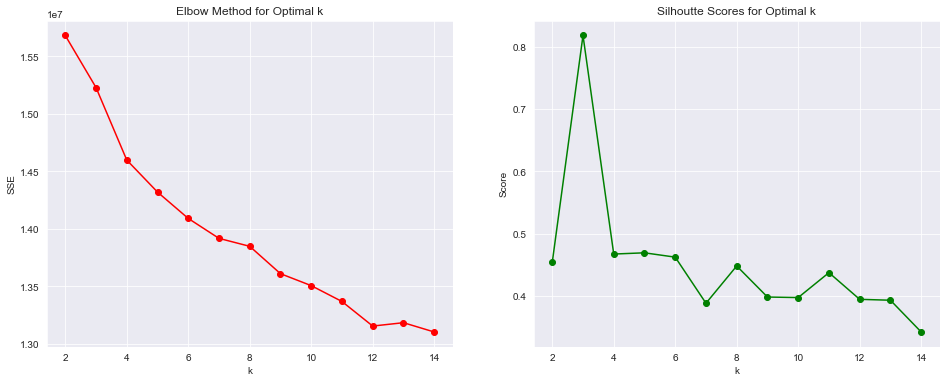

In [23]:
inertias = {}
silhoutte_scores = {}

for k in range(2, 15):
    kmeans_initial = KMeans(n_clusters = k, random_state = 45)
    kmeans_initial.fit(vector_df)
    
    silhoutte_scores[k] = silhouette_score(vector_df, kmeans_initial.predict(vector_df))

    inertias[k] = kmeans_initial.inertia_

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)

plt.plot(inertias.keys(), inertias.values(), 'ro-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)

plt.plot(silhoutte_scores.keys(), silhoutte_scores.values(), 'go-')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Silhoutte Scores for Optimal k')

plt.show()

**Function khusus dibuat untuk menggabungkan data asli dan label dengan mudah.**

Function ini cukup berguna jika kita mau mencoba tuning clusteringnya.

In [40]:
def combine_labels(df, vector_df, labels):
    '''
        Combine labels with the original DataFrame 
        to make clustering results easier to evaluate
    '''
    
    vector_df['cluster'] = labels
    
    result_df = df.merge(vector_df, how = 'left', 
                         left_on = 'freebase_ID', right_index = True)

    return result_df

In [77]:
kmeans_k = KMeans(n_clusters = 6, random_state = 13)
kmeans_k.fit(vector_df)

y_preds = kmeans_k.predict(vector_df)
result_df = combine_labels(df, vector_df, y_preds)

display_df(result_df)

,wikipedia_ID,freebase_ID,title,author,summary,publication_year,clean_summary,noiseless_summary,Doc2Vec 1,Doc2Vec 2,...,wyoming,yale,yeerks,yorkshire,yugoslavia,yuuzhan vong,zurich,publication_period,summary_length,cluster
0,620,/m/0hhy,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",1945.0,"[old, major, old, boar, manor, farm, call, ani...",Old Major the old boar on the Manor Farm calls...,-0.455896,-0.859372,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.550279,1.098927,0
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",1962.0,"[alex, teenag, live, near, futur, england, lea...",Alex a teenager living in near future England ...,-0.397816,0.308984,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.049087,1.334585,0
2,986,/m/0ldx,The Plague,Albert Camus,The text of The Plague is divided into five p...,1947.0,"[text, plagu, divid, part, town, oran, thousan...",The text of The Plague is divided into five pa...,-0.806132,0.267149,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.550279,1.393499,0
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,The argument of the Enquiry proceeds by a ser...,1748.0,"[argument, enquiri, proceed, seri, increment, ...",The argument of the Enquiry proceeds by a seri...,3.690177,-0.861527,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-2.552664,4.604337,0
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,1992.0,"[novel, posit, space, around, milki, way, divi...",The novel posits that space around the Milky W...,-0.266197,2.572674,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,0.454490,0.704936,0


(16559, 1113)

**Hasil clustering akan disimpan karena angka cluster selalu berubah.**

Karena K-Means tidak deterministik (parameter yang sama dijalankan di saat atau urutan yang berbeda bisa menghasilkan berbeda), maka hasil clustering kali ini disimpan dulu untuk dipakai di evaluasi.

In [88]:
result_df.to_feather('result_df (final).feather')

## **Evaluation**

In [89]:
result_df = pd.read_feather('result_df (final).feather')

display_df(result_df)

,wikipedia_ID,freebase_ID,title,author,summary,publication_year,clean_summary,noiseless_summary,Doc2Vec 1,Doc2Vec 2,...,wyoming,yale,yeerks,yorkshire,yugoslavia,yuuzhan vong,zurich,publication_period,summary_length,cluster
0,620,/m/0hhy,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",1945.0,"[old, major, old, boar, manor, farm, call, ani...",Old Major the old boar on the Manor Farm calls...,-0.455896,-0.859372,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.550279,1.098927,0
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",1962.0,"[alex, teenag, live, near, futur, england, lea...",Alex a teenager living in near future England ...,-0.397816,0.308984,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.049087,1.334585,0
2,986,/m/0ldx,The Plague,Albert Camus,The text of The Plague is divided into five p...,1947.0,"[text, plagu, divid, part, town, oran, thousan...",The text of The Plague is divided into five pa...,-0.806132,0.267149,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-1.550279,1.393499,0
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,The argument of the Enquiry proceeds by a ser...,1748.0,"[argument, enquiri, proceed, seri, increment, ...",The argument of the Enquiry proceeds by a seri...,3.690177,-0.861527,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-2.552664,4.604337,0
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,1992.0,"[novel, posit, space, around, milki, way, divi...",The novel posits that space around the Milky W...,-0.266197,2.572674,...,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,-0.036046,0.454490,0.704936,0


(16559, 1113)

**Setiap cluster akan diperiksa untuk melihat cluster itu sebenarnya tentang apa.**

Hasil dibaca dari file feather yang telah disimpan karena hasil clustering akan selalu berubah setiap kali dijalankan ulang, sementara ada bagian notebook yang memakan waktu signifikan sehingga tidak praktikal jika dijalankan ulang terlalu sering.

<u>**TO BE CONTINUED**</u>  
Evaluasi per cluster serta rekomendasi sedang _under renovation_ dan akan dilakukan pada update selanjutnya!